# This file uses sentiment, price, and company factors data. Since the sentiment data starts from 2020. All data used in this file only includes records starting from 2020.
## Aggregated training is better than separate training.
## since we only have data on 2020-2023, its performance is not as good (still better than BERT and SARIMA). The best performing model is in the file LSTM_pricecf_2000.ipynb. (There we have ample data from 2000, but we lost sentiment information)
## also used in comparison to LSTM_sentiprice_nocf_2020.ipynb to see that company factors are indeed optional.

In [ ]:
import pandas as pd
import numpy as np
import h5py
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
import tensorflow as tf

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import random

random.seed(42)

# Get Data and Preprocess for the model

In [ ]:
Xy_train = pd.read_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_train_wcf.csv')
Xy_val = pd.read_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_val_wcf.csv')
LOOKBACK = 60

In [ ]:
Xy_train.isna().sum().sum()

0

In [ ]:
Xy_val.isna().sum().sum()

0

In [ ]:
Xy_train.columns

Index(['security', 'date_x', 'RELEVANT_SENTIMENT_SCORE_mean',
       'RELEVANT_SENTIMENT_SCORE_min', 'RELEVANT_SENTIMENT_SCORE_max', 'Open',
       'High', 'Low', 'Close', 'Adj Close', 'Volume', 'month',
       'TRAIL_12M_NET_SALES', 'TRAIL_12M_EPS', 'TRAIL_12M_OPER_MARGIN',
       'EV_TO_T12M_EBITDA', 'ENTERPRISE_VALUE', 'BEST_PE_RATIO', 'PX_LAST',
       'BEST_SALES', 'BEST_EPS', 'BEST_CUR_EV_TO_EBITDA', 'TRAIL_12M_EBITDA',
       'CUR_MKT_CAP', 'VOLUME', 'TRAIL_12M_GROSS_MARGIN', 'EBIT_MARGIN',
       'BEST_LTG_EPS', 'IS_DIV_PER_SHR', 'EBITDA_MARGIN',
       'TOT_DEBT_TO_TOT_ASSET', 'SALES_GROWTH', 'EPS_GROWTH', 'SALES_TO_CASH',
       'CURRENT_EV_TO_T12M_EBITDA', 'PE_RATIO', 'EQY_SH_OUT', 'SHORT_INT',
       'SI_PERCENT_EQUITY_FLOAT', 'RSK_BB_IMPLIED_CDS_SPREAD', 'IVOL_DELTA',
       'OPEN_INT_TOTAL_CALL', 'OPEN_INT_TOTAL_PUT', 'PX_TO_BOOK_RATIO',
       'TOT_DEBT_TO_TOT_EQY', 'TOT_DEBT_TO_EBITDA', 'RETURN_COM_EQY',
       'TANG_BOOK_VAL_PER_SH', 'NET_DEBT', 'BEST_EBITDA', 'TRAIL_1

In [ ]:
FINAL_FEATURES = []
for col in list(Xy_train.columns):
  if col != 'security' and col != 'date_x' and col !=  'month' and col != 'date_y' and col != 'MONTHLY_RETURN' and col !=  'MONTHLY_RETURN_F1':
    FINAL_FEATURES.append(col)

In [ ]:
FINAL_FEATURES

['RELEVANT_SENTIMENT_SCORE_mean',
 'RELEVANT_SENTIMENT_SCORE_min',
 'RELEVANT_SENTIMENT_SCORE_max',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'TRAIL_12M_NET_SALES',
 'TRAIL_12M_EPS',
 'TRAIL_12M_OPER_MARGIN',
 'EV_TO_T12M_EBITDA',
 'ENTERPRISE_VALUE',
 'BEST_PE_RATIO',
 'PX_LAST',
 'BEST_SALES',
 'BEST_EPS',
 'BEST_CUR_EV_TO_EBITDA',
 'TRAIL_12M_EBITDA',
 'CUR_MKT_CAP',
 'VOLUME',
 'TRAIL_12M_GROSS_MARGIN',
 'EBIT_MARGIN',
 'BEST_LTG_EPS',
 'IS_DIV_PER_SHR',
 'EBITDA_MARGIN',
 'TOT_DEBT_TO_TOT_ASSET',
 'SALES_GROWTH',
 'EPS_GROWTH',
 'SALES_TO_CASH',
 'CURRENT_EV_TO_T12M_EBITDA',
 'PE_RATIO',
 'EQY_SH_OUT',
 'SHORT_INT',
 'SI_PERCENT_EQUITY_FLOAT',
 'RSK_BB_IMPLIED_CDS_SPREAD',
 'IVOL_DELTA',
 'OPEN_INT_TOTAL_CALL',
 'OPEN_INT_TOTAL_PUT',
 'PX_TO_BOOK_RATIO',
 'TOT_DEBT_TO_TOT_EQY',
 'TOT_DEBT_TO_EBITDA',
 'RETURN_COM_EQY',
 'TANG_BOOK_VAL_PER_SH',
 'NET_DEBT',
 'BEST_EBITDA',
 'TRAIL_12M_OPER_INC',
 'TRAIL_12M_CAP_EXPEND',
 'FREE_CASH_FLOW_YIELD',
 'TRAIL_12M_FREE_

In [ ]:
def get_ONE_datav1(Xy_train, Xy_val, LOOKBACK, task, features):
  """
  return X,y seperately for all 25 stocks.
  stock25 = {'security1':{'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
    Note: for LSTM the X_train and y_train contains a 3D matrix (samples, window_span, features); y_train and y_val are (sample,)
  """
  # organize features
  if task == 'current':
    f = features.copy()
    f.append('MONTHLY_RETURN')
  else:
    f = features.copy()
    f.append('MONTHLY_RETURN_F1')

  print(f"TASK:{task}")
  securities = list(Xy_train.security.unique())
  X_train = []
  y_train = []
  X_val = []
  y_val = []
  for security in securities:
    # train
    train_stock = Xy_train[Xy_train['security']==security][f].values # take sure columns are int he right order
    if len(train_stock) == 0:
        print(f'Error, size of train stock {security} =0')
        return
    scalar_stock_train = StandardScaler()
    train_stock_scaled = scalar_stock_train.fit_transform(train_stock)

    # validation
    val_stock = Xy_val[Xy_val['security']==security][f].values
    if len(val_stock) == 0:
        print(f'Error, size of val stock {security} =0')
        return
    scalar_stock_val = StandardScaler()
    val_stock_scaled = scalar_stock_val.fit_transform(val_stock)

    X_train_stock = []
    y_train_stock = []
    X_val_stock = []
    y_val_stock = []

    # train
    for i in range(LOOKBACK, len(train_stock_scaled)):
        #X_train_stock.append(train_stock_scaled[i - LOOKBACK:i, :-1]) #
        X_train.append(train_stock_scaled[i - LOOKBACK:i, :-1])
        #y_train_stock.append(train_stock_scaled[i, -1]) # last column in Xy_train as y_train
        y_train.append(train_stock_scaled[i, -1])

    #X_train_stock, y_train_stock = np.array(X_train_stock),np.array(y_train_stock)

    # validation
    for i in range(LOOKBACK, len(val_stock_scaled)):
        #X_val_stock.append(val_stock_scaled[i - LOOKBACK:i, :-1])
        X_val.append(val_stock_scaled[i - LOOKBACK:i, :-1])
        #y_val_stock.append(val_stock_scaled[i, -1])
        y_val.append(val_stock_scaled[i, -1])

    #X_val_stock, y_val_stock = np.array(X_val_stock),np.array(y_val_stock)

    #print(f'{security}: X_train shape :{X_train_stock.shape}, y_train shape:{y_train_stock.shape}; X_val shape :{X_val_stock.shape}, y_val shape:{y_val_stock.shape}')

  X_train, y_train = np.array(X_train),np.array(y_train)
  X_val, y_val = np.array(X_val),np.array(y_val)
  stocks = {} # a dict : {'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
  stocks['X_train'] = X_train
  stocks['y_train'] = y_train
  stocks['X_val'] = X_val
  stocks['y_val'] = y_val
  print(f'X_train shape :{X_train.shape}, y_train shape:{y_train.shape}; X_val shape :{X_val.shape}, y_val shape:{y_val.shape}')
  return stocks



In [ ]:
def get_data(Xy_train, Xy_val, LOOKBACK, task, features):
  """
  return X,y seperately for all 25 stocks.
  stock25 = {'security1':{'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
    Note: for LSTM the X_train and y_train contains a 3D matrix (samples, window_span, features); y_train and y_val are (sample,)
  """
  # organize features
  if task == 'current':
    f = features.copy()
    f.append('MONTHLY_RETURN')
  else:
    f = features.copy()
    f.append('MONTHLY_RETURN_F1')

  print(f"TASK:{task}")
  stocks25 = {} # a dict of dicts : {'security1':{'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
  securities = list(Xy_train.security.unique())
  for security in securities:
    # train
    train_stock = Xy_train[Xy_train['security']==security][f].values # take sure columns are int he right order
    if len(train_stock) == 0:
        print(f'Error, size of train stock {security} =0')
        return
    scalar_stock_train = StandardScaler()
    train_stock_scaled = scalar_stock_train.fit_transform(train_stock)

    # validation
    val_stock = Xy_val[Xy_val['security']==security][f].values
    if len(val_stock) == 0:
        print(f'Error, size of val stock {security} =0')
        return
    scalar_stock_val = StandardScaler()
    val_stock_scaled = scalar_stock_val.fit_transform(val_stock)

    X_train_stock = []
    y_train_stock = []
    X_val_stock = []
    y_val_stock = []

    # train
    for i in range(LOOKBACK, len(train_stock_scaled)):
        X_train_stock.append(train_stock_scaled[i - LOOKBACK:i, :-1]) #
        y_train_stock.append(train_stock_scaled[i, -1]) # last column in Xy_train as y_train

    X_train_stock, y_train_stock = np.array(X_train_stock),np.array(y_train_stock)

    # validation
    for i in range(LOOKBACK, len(val_stock_scaled)):
        X_val_stock.append(val_stock_scaled[i - LOOKBACK:i, :-1])
        y_val_stock.append(val_stock_scaled[i, -1])

    X_val_stock, y_val_stock = np.array(X_val_stock),np.array(y_val_stock)

    print(f'{security}: X_train shape :{X_train_stock.shape}, y_train shape:{y_train_stock.shape}; X_val shape :{X_val_stock.shape}, y_val shape:{y_val_stock.shape}')

    stock_og = {}
    stock_og['X_train'] = X_train_stock
    stock_og['y_train'] = y_train_stock
    stock_og['X_val'] = X_val_stock
    stock_og['y_val'] = y_val_stock
    stocks25[security] = stock_og

  return stocks25


def get_ONE_datav2(Xy_train, Xy_val, LOOKBACK, task, features):
  """
  returns one dataset for all stocks, the security infomation is lost.
  stocks = {'X_train':data, 'X_val':data .. }
   Note: for LSTM the X_train and y_train contains a 3D matrix (samples, window_span, features); y_train and y_val are (sample,)
  """
  # organize features
  if task == 'current':
    f = features.copy()
    f.append('MONTHLY_RETURN')
  else:
    f = features.copy()
    f.append('MONTHLY_RETURN_F1')

  print(f"TASK:{task}")

  # train
  train_stock = Xy_train[f].values # take sure columns are int he right order
  scalar_stock_train = StandardScaler()
  train_stock_scaled = scalar_stock_train.fit_transform(train_stock)

  # validation
  val_stock = Xy_val[f].values
  scalar_stock_val = StandardScaler()
  val_stock_scaled = scalar_stock_val.fit_transform(val_stock)

  X_train_stock = []
  y_train_stock = []
  X_val_stock = []
  y_val_stock = []

  # train
  for i in range(LOOKBACK, len(train_stock_scaled)):
      X_train_stock.append(train_stock_scaled[i - LOOKBACK:i, :-1]) #
      y_train_stock.append(train_stock_scaled[i, -1]) # last column in Xy_train as y_train

  X_train_stock, y_train_stock = np.array(X_train_stock),np.array(y_train_stock)

  # validation
  for i in range(LOOKBACK, len(val_stock_scaled)):
      X_val_stock.append(val_stock_scaled[i - LOOKBACK:i, :-1])
      y_val_stock.append(val_stock_scaled[i, -1])

  X_val_stock, y_val_stock = np.array(X_val_stock),np.array(y_val_stock)

  stocks = {} # a dict : {'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
  stocks['X_train'] = X_train_stock
  stocks['y_train'] = y_train_stock
  stocks['X_val'] = X_val_stock
  stocks['y_val'] = y_val_stock
  print(f'X_train shape :{X_train_stock.shape}, y_train shape:{y_train_stock.shape}; X_val shape :{X_val_stock.shape}, y_val shape:{y_val_stock.shape}')

  return stocks


In [ ]:
stock25_cur = get_data(Xy_train, Xy_val, LOOKBACK, 'current', FINAL_FEATURES)
stock25_next = get_data(Xy_train, Xy_val, LOOKBACK, 'next',FINAL_FEATURES)

TASK:current
AMZN US Equity: X_train shape :(679, 60, 90), y_train shape:(679,); X_val shape :(410, 60, 90), y_val shape:(410,)
APTV US Equity: X_train shape :(520, 60, 90), y_train shape:(520,); X_val shape :(316, 60, 90), y_val shape:(316,)
AZO US Equity: X_train shape :(521, 60, 90), y_train shape:(521,); X_val shape :(314, 60, 90), y_val shape:(314,)
BKNG US Equity: X_train shape :(514, 60, 90), y_train shape:(514,); X_val shape :(324, 60, 90), y_val shape:(324,)
CCL US Equity: X_train shape :(523, 60, 90), y_train shape:(523,); X_val shape :(314, 60, 90), y_val shape:(314,)
CMG US Equity: X_train shape :(515, 60, 90), y_train shape:(515,); X_val shape :(325, 60, 90), y_val shape:(325,)
DG US Equity: X_train shape :(520, 60, 90), y_train shape:(520,); X_val shape :(306, 60, 90), y_val shape:(306,)
EBAY US Equity: X_train shape :(535, 60, 90), y_train shape:(535,); X_val shape :(325, 60, 90), y_val shape:(325,)
F US Equity: X_train shape :(650, 60, 90), y_train shape:(650,); X_val s

In [ ]:
stock_ONE_curv1 = get_ONE_datav1(Xy_train, Xy_val, LOOKBACK,  'current',FINAL_FEATURES)
stock_ONE_nextv1 = get_ONE_datav1(Xy_train, Xy_val, LOOKBACK, 'next',FINAL_FEATURES)

TASK:current
X_train shape :(13534, 60, 90), y_train shape:(13534,); X_val shape :(8377, 60, 90), y_val shape:(8377,)
TASK:next
X_train shape :(13534, 60, 90), y_train shape:(13534,); X_val shape :(8377, 60, 90), y_val shape:(8377,)


In [ ]:
stock_ONE_curv2 = get_ONE_datav2(Xy_train, Xy_val, LOOKBACK,  'current',FINAL_FEATURES)
stock_ONE_nextv2 = get_ONE_datav2(Xy_train, Xy_val, LOOKBACK, 'next',FINAL_FEATURES)

TASK:current
X_train shape :(14974, 60, 90), y_train shape:(14974,); X_val shape :(9817, 60, 90), y_val shape:(9817,)
TASK:next
X_train shape :(14974, 60, 90), y_train shape:(14974,); X_val shape :(9817, 60, 90), y_val shape:(9817,)


# Modeling

In [ ]:
# Initializing the Neural Network based on LSTM
# implemented in this paper: https://www.sciencedirect.com/science/article/pii/S1877050920304865?via%3Dihub
def create_model(inputcol, lr, inputrow = LOOKBACK):
    model = Sequential([
        LSTM(96, return_sequences=True, input_shape=(inputrow, inputcol)),  # input_shape matches the features of X_train
        Dropout(0.2),
        LSTM(96, return_sequences=True),
        Dropout(0.2),
        LSTM(96, return_sequences=True),
        Dropout(0.2),
        LSTM(96),  # Last LSTM layer should not return sequences
        Dropout(0.2),
        Dense(1, activation='linear')  # Single unit for regression output
    ])
    # Compiling the Neural Network
    model.compile(optimizer = Adam(learning_rate=lr), loss='mean_squared_error')
    return model

In [ ]:
def train_aggregate_model(train_df = None, val_df = None, task = None, N_epoch = 30):
  """
  train on all stock data, but used to predict individual stocks.
  data: in stocks25 format
  return: dict pred25 that contains evaluation stats and y_pred vs y for each stock.
          {'stockname':{'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}...}
  """
  X_train = train_df['X_train']
  y_train = train_df['y_train']
  for k,v in train_df.items(): # k is the dataset name: X_train, y_val .etc
    if k == 'X_train':
      single_day_feature_dim = v.shape[2]
      break
  assert single_day_feature_dim == 90

  stock_model = create_model(single_day_feature_dim, 0.01)
  es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
  rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
  mcp = ModelCheckpoint(filepath=f'weights_task_{task}_aggregate_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
  tb = TensorBoard('logs')
  stock_history = stock_model.fit(X_train, y_train, shuffle=True, epochs=N_epoch, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=32)
  SAVE_PATH = f'/content/gdrive/MyDrive/lazard/models/task_{task}/task_{task}_aggregate_model.h5'
  stock_model.save(SAVE_PATH)

  pred25 = {}
  for key,val in val_df.items():
    print(f'\n\n-------------------{key}--------------------')
    stock_X_val = val["X_val"]
    stock_y_val = val['y_val']

    # predict
    y_preds = stock_model.predict(stock_X_val)
    r_squared_adjusted = r2_score(stock_y_val, y_preds)
    mse = mean_squared_error(stock_y_val, y_preds)
    rmse = np.sqrt(mse)
    pred_org = {'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}
    pred25[key]=pred_org

  return pred25

In [ ]:
def run_model(data, task, N_epoch = 30):
  """
  train model stock by stock, so 25 models for the specified task and evaluate on that specific stock data.
  data: {'securityname': {'X_train':data, 'y_train':data.....}}
  return: dict pred25 that contains evaluation stats and y_pred vs y for each stock.
          {'stockname':{'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}...}
  """
  for key,val in data.items(): # key is the stock name
    for k,v in val.items(): # k is the dataset name: X_train, y_val .etc
      if k == 'X_train':
        single_day_feature_dim = v.shape[2]
        break
  assert single_day_feature_dim == 90

  pred25 = {}
  for key,val in data.items():
    print(f'\n\n-------------------{key}--------------------')
    stock_X_train = val['X_train']
    stock_y_train = val['y_train']
    stock_X_val = val["X_val"]
    stock_y_val = val['y_val']

    # train model
    stock_model = create_model(single_day_feature_dim,0.01)
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
    mcp = ModelCheckpoint(filepath=f'weights_task_{task}_{key}_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    tb = TensorBoard('logs')
    stock_history = stock_model.fit(stock_X_train, stock_y_train, shuffle=True, epochs=N_epoch, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=32)
    SAVE_PATH = f'/content/gdrive/MyDrive/lazard/models/task_{task}/task_{task}_{key}_model.h5'
    stock_model.save(SAVE_PATH)
    # predict
    y_preds = stock_model.predict(stock_X_val)
    r_squared_adjusted = r2_score(stock_y_val, y_preds)
    mse = mean_squared_error(stock_y_val, y_preds)
    rmse = np.sqrt(mse)
    pred_org = {'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}
    pred25[key]=pred_org

  return pred25



In [ ]:
def analyze(pred25_cur, TASK, mode):
    """
    generate prediction vs y_true plot
    save evaluation metrics to path.
    """
    # Iterate over each stock in the dictionary
    for stock_name, predictions in pred25_cur.items():
        y_preds = predictions['y_preds']
        y = predictions['y']

        # Create a figure and axis
        fig, ax = plt.subplots()
        print(f'y vs y_pred: {y.shape} vs {y_preds.shape}')


        # Plot the real returns (y) in blue
        ax.plot(y, label='Real Returns', color='blue')

        # Plot the predicted returns (y_preds) in red
        ax.plot(y_preds, label='Predicted Returns', color='red')

        # Set axis labels and a legend
        ax.set_xlabel('Time')
        ax.set_ylabel('Returns')
        ax.set_title(f'{stock_name} - Real vs. Predicted Returns')
        ax.legend()

        # Display or save the plot as needed
        plt.show()  # Use
        #plot_path = f'/content/gdrive/MyDrive/lazard/models/task_{TASK}/outputs/{mode}LSTM_{TASK}_lr0.01_nocomp.png'
        #plt.savefig(plot_path) # to save the plot to a file

    pred25_cur = pd.DataFrame(pred25_cur)
    analysis_path = f'/content/gdrive/MyDrive/lazard/models/task_{TASK}/outputs/{mode}LSTM_{TASK}_lr0.01_comp.csv'
    pred25_cur.to_csv(analysis_path)
    return pred25_cur




## Task : predict 'MONTHLY_RETURN'

### Separate model each stock

In [ ]:
TASK = 'current'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1

mode = 'sep'

pred25_cur = run_model(df25, TASK) # run 25 separate models and evaluate



-------------------AMZN US Equity--------------------
Epoch 1/30
16/17 [===========================>..] - ETA: 0s - loss: 0.9488
Epoch 1: val_loss improved from inf to 0.78020, saving model to weights_task_current_AMZN US Equity_model.h5
17/17 [==============================] - 10s 108ms/step - loss: 0.9566 - val_loss: 0.7802 - lr: 0.0100
Epoch 2/30
16/17 [===========================>..] - ETA: 0s - loss: 0.6055
Epoch 2: val_loss improved from 0.78020 to 0.54466, saving model to weights_task_current_AMZN US Equity_model.h5
17/17 [==============================] - 0s 26ms/step - loss: 0.5893 - val_loss: 0.5447 - lr: 0.0100
Epoch 3/30
16/17 [===========================>..] - ETA: 0s - loss: 0.5700
Epoch 3: val_loss did not improve from 0.54466
17/17 [==============================] - 0s 22ms/step - loss: 0.5583 - val_loss: 0.6952 - lr: 0.0100
Epoch 4/30
16/17 [===========================>..] - ETA: 0s - loss: 0.4311
Epoch 4: val_loss did not improve from 0.54466
17/17 [================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 1s 7ms/step


-------------------APTV US Equity--------------------
Epoch 1/30
10/13 [======================>.......] - ETA: 0s - loss: 0.9693
Epoch 1: val_loss improved from inf to 0.42695, saving model to weights_task_current_APTV US Equity_model.h5
13/13 [==============================] - 9s 186ms/step - loss: 0.9107 - val_loss: 0.4270 - lr: 0.0100
Epoch 2/30
11/13 [========================>.....] - ETA: 0s - loss: 0.5188
Epoch 2: val_loss did not improve from 0.42695
13/13 [==============================] - 0s 33ms/step - loss: 0.5028 - val_loss: 0.5710 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.2553
Epoch 3: val_loss did not improve from 0.42695
13/13 [==============================] - 0s 31ms/step - loss: 0.2553 - val_loss: 0.4438 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.2287
Epoch 4: val_loss did not improve from 0.42695
13/13 [==============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 8ms/step


-------------------AZO US Equity--------------------
Epoch 1/30
12/13 [==========================>...] - ETA: 0s - loss: 0.9465
Epoch 1: val_loss improved from inf to 1.06582, saving model to weights_task_current_AZO US Equity_model.h5
13/13 [==============================] - 9s 204ms/step - loss: 0.9213 - val_loss: 1.0658 - lr: 0.0100
Epoch 2/30
12/13 [==========================>...] - ETA: 0s - loss: 0.5108
Epoch 2: val_loss improved from 1.06582 to 0.82140, saving model to weights_task_current_AZO US Equity_model.h5
13/13 [==============================] - 0s 32ms/step - loss: 0.5387 - val_loss: 0.8214 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.5288
Epoch 3: val_loss did not improve from 0.82140
13/13 [==============================] - 0s 21ms/step - loss: 0.5288 - val_loss: 0.8898 - lr: 0.0100
Epoch 4/30
12/13 [==========================>...] - ETA: 0s - loss: 0.4002
Epoch 4: val_loss did

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 7ms/step


-------------------BKNG US Equity--------------------
Epoch 1/30
11/13 [========================>.....] - ETA: 0s - loss: 1.0966
Epoch 1: val_loss improved from inf to 1.09254, saving model to weights_task_current_BKNG US Equity_model.h5
13/13 [==============================] - 10s 136ms/step - loss: 1.0658 - val_loss: 1.0925 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.7243
Epoch 2: val_loss did not improve from 1.09254
13/13 [==============================] - 0s 24ms/step - loss: 0.7243 - val_loss: 1.3716 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.6358
Epoch 3: val_loss improved from 1.09254 to 0.89536, saving model to weights_task_current_BKNG US Equity_model.h5
13/13 [==============================] - 0s 24ms/step - loss: 0.6358 - val_loss: 0.8954 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.6330
Epoch 4: val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 3s 12ms/step


-------------------CCL US Equity--------------------
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 1.0328
Epoch 1: val_loss improved from inf to 0.51102, saving model to weights_task_current_CCL US Equity_model.h5
14/14 [==============================] - 8s 124ms/step - loss: 1.0328 - val_loss: 0.5110 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.6919
Epoch 2: val_loss improved from 0.51102 to 0.25865, saving model to weights_task_current_CCL US Equity_model.h5
14/14 [==============================] - 0s 27ms/step - loss: 0.6891 - val_loss: 0.2586 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.5037
Epoch 3: val_loss did not improve from 0.25865
14/14 [==============================] - 0s 23ms/step - loss: 0.5016 - val_loss: 0.5296 - lr: 0.0100
Epoch 4/30
12/14 [========================>.....] - ETA: 0s - loss: 0.4804
Epoch 4: val_loss di

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 9ms/step


-------------------CMG US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 1.0821
Epoch 1: val_loss improved from inf to 0.86478, saving model to weights_task_current_CMG US Equity_model.h5
13/13 [==============================] - 9s 207ms/step - loss: 1.0821 - val_loss: 0.8648 - lr: 0.0100
Epoch 2/30
12/13 [==========================>...] - ETA: 0s - loss: 0.4358
Epoch 2: val_loss improved from 0.86478 to 0.53919, saving model to weights_task_current_CMG US Equity_model.h5
13/13 [==============================] - 0s 34ms/step - loss: 0.4277 - val_loss: 0.5392 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.4112
Epoch 3: val_loss did not improve from 0.53919
13/13 [==============================] - 0s 32ms/step - loss: 0.4112 - val_loss: 0.8088 - lr: 0.0100
Epoch 4/30
12/13 [==========================>...] - ETA: 0s - loss: 0.3969
Epoch 4: val_loss did

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 8ms/step


-------------------DG US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.7808
Epoch 1: val_loss improved from inf to 2.06159, saving model to weights_task_current_DG US Equity_model.h5
13/13 [==============================] - 10s 134ms/step - loss: 0.7808 - val_loss: 2.0616 - lr: 0.0100
Epoch 2/30
11/13 [========================>.....] - ETA: 0s - loss: 0.4251
Epoch 2: val_loss improved from 2.06159 to 1.87557, saving model to weights_task_current_DG US Equity_model.h5
13/13 [==============================] - 0s 27ms/step - loss: 0.4440 - val_loss: 1.8756 - lr: 0.0100
Epoch 3/30
12/13 [==========================>...] - ETA: 0s - loss: 0.2830
Epoch 3: val_loss improved from 1.87557 to 1.42033, saving model to weights_task_current_DG US Equity_model.h5
13/13 [==============================] - 0s 23ms/step - loss: 0.2789 - val_loss: 1.4203 - lr: 0.0100
Epoch 4/30
12/13 [================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 2s 7ms/step


-------------------EBAY US Equity--------------------
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 1.0685
Epoch 1: val_loss improved from inf to 1.23292, saving model to weights_task_current_EBAY US Equity_model.h5
14/14 [==============================] - 9s 130ms/step - loss: 1.0685 - val_loss: 1.2329 - lr: 0.0100
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.6795
Epoch 2: val_loss did not improve from 1.23292
14/14 [==============================] - 0s 30ms/step - loss: 0.6795 - val_loss: 1.2947 - lr: 0.0100
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.6121
Epoch 3: val_loss improved from 1.23292 to 0.28286, saving model to weights_task_current_EBAY US Equity_model.h5
14/14 [==============================] - 0s 35ms/step - loss: 0.6121 - val_loss: 0.2829 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.5978
Epoch 4: val_loss 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 7ms/step


-------------------F US Equity--------------------
Epoch 1/30
16/17 [===========================>..] - ETA: 0s - loss: 1.1620
Epoch 1: val_loss improved from inf to 0.63184, saving model to weights_task_current_F US Equity_model.h5
17/17 [==============================] - 10s 108ms/step - loss: 1.1507 - val_loss: 0.6318 - lr: 0.0100
Epoch 2/30
16/17 [===========================>..] - ETA: 0s - loss: 0.5544
Epoch 2: val_loss improved from 0.63184 to 0.31362, saving model to weights_task_current_F US Equity_model.h5
17/17 [==============================] - 0s 26ms/step - loss: 0.5500 - val_loss: 0.3136 - lr: 0.0100
Epoch 3/30
16/17 [===========================>..] - ETA: 0s - loss: 0.3181
Epoch 3: val_loss did not improve from 0.31362
17/17 [==============================] - 0s 22ms/step - loss: 0.3177 - val_loss: 0.9663 - lr: 0.0100
Epoch 4/30
16/17 [===========================>..] - ETA: 0s - loss: 0.2356
Epoch 4: val_loss did not 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 2s 7ms/step


-------------------GM US Equity--------------------
Epoch 1/30
17/18 [===========================>..] - ETA: 0s - loss: 1.0589
Epoch 1: val_loss improved from inf to 0.53683, saving model to weights_task_current_GM US Equity_model.h5
18/18 [==============================] - 10s 156ms/step - loss: 1.0529 - val_loss: 0.5368 - lr: 0.0100
Epoch 2/30
17/18 [===========================>..] - ETA: 0s - loss: 0.6359
Epoch 2: val_loss improved from 0.53683 to 0.48999, saving model to weights_task_current_GM US Equity_model.h5
18/18 [==============================] - 1s 37ms/step - loss: 0.6331 - val_loss: 0.4900 - lr: 0.0100
Epoch 3/30
17/18 [===========================>..] - ETA: 0s - loss: 0.5210
Epoch 3: val_loss did not improve from 0.48999
18/18 [==============================] - 1s 31ms/step - loss: 0.5167 - val_loss: 0.4919 - lr: 0.0100
Epoch 4/30
17/18 [===========================>..] - ETA: 0s - loss: 0.3681
Epoch 4: val_loss impro

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 7ms/step


-------------------HD US Equity--------------------
Epoch 1/30
12/13 [==========================>...] - ETA: 0s - loss: 0.8466
Epoch 1: val_loss improved from inf to 2.26808, saving model to weights_task_current_HD US Equity_model.h5
13/13 [==============================] - 10s 149ms/step - loss: 0.8437 - val_loss: 2.2681 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.4633
Epoch 2: val_loss did not improve from 2.26808
13/13 [==============================] - 0s 24ms/step - loss: 0.4633 - val_loss: 6.2274 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.2915
Epoch 3: val_loss did not improve from 2.26808
13/13 [==============================] - 0s 27ms/step - loss: 0.2915 - val_loss: 8.0250 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.2602
Epoch 4: val_loss did not improve from 2.26808
13/13 [==============================] -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 7ms/step


-------------------HLT US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 1.1711
Epoch 1: val_loss improved from inf to 0.59538, saving model to weights_task_current_HLT US Equity_model.h5
14/14 [==============================] - 10s 130ms/step - loss: 1.1686 - val_loss: 0.5954 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.7277
Epoch 2: val_loss did not improve from 0.59538
14/14 [==============================] - 0s 23ms/step - loss: 0.7330 - val_loss: 0.6029 - lr: 0.0100
Epoch 3/30
12/14 [========================>.....] - ETA: 0s - loss: 0.6821
Epoch 3: val_loss did not improve from 0.59538
14/14 [==============================] - 0s 24ms/step - loss: 0.6958 - val_loss: 0.6312 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.6136
Epoch 4: val_loss did not improve from 0.59538
14/14 [==============================]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 2s 11ms/step


-------------------LOW US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 0.8359
Epoch 1: val_loss improved from inf to 2.16001, saving model to weights_task_current_LOW US Equity_model.h5
14/14 [==============================] - 10s 133ms/step - loss: 0.8378 - val_loss: 2.1600 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.4501
Epoch 2: val_loss did not improve from 2.16001
14/14 [==============================] - 0s 27ms/step - loss: 0.4495 - val_loss: 2.3772 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.3794
Epoch 3: val_loss did not improve from 2.16001
14/14 [==============================] - 0s 33ms/step - loss: 0.3811 - val_loss: 3.7823 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.3268
Epoch 4: val_loss did not improve from 2.16001
14/14 [==============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 7ms/step


-------------------LVS US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 1.2051
Epoch 1: val_loss improved from inf to 0.67122, saving model to weights_task_current_LVS US Equity_model.h5
13/13 [==============================] - 10s 142ms/step - loss: 1.2051 - val_loss: 0.6712 - lr: 0.0100
Epoch 2/30
11/13 [========================>.....] - ETA: 0s - loss: 0.5525
Epoch 2: val_loss improved from 0.67122 to 0.58591, saving model to weights_task_current_LVS US Equity_model.h5
13/13 [==============================] - 0s 27ms/step - loss: 0.5548 - val_loss: 0.5859 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.5404
Epoch 3: val_loss did not improve from 0.58591
13/13 [==============================] - 0s 26ms/step - loss: 0.5404 - val_loss: 0.9822 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.5447
Epoch 4: val_loss di

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 7ms/step


-------------------MAR US Equity--------------------
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 1.1832
Epoch 1: val_loss improved from inf to 0.24320, saving model to weights_task_current_MAR US Equity_model.h5
14/14 [==============================] - 10s 151ms/step - loss: 1.1832 - val_loss: 0.2432 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.9177
Epoch 2: val_loss did not improve from 0.24320
14/14 [==============================] - 0s 22ms/step - loss: 0.9289 - val_loss: 0.4329 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.8602
Epoch 3: val_loss did not improve from 0.24320
14/14 [==============================] - 0s 24ms/step - loss: 0.8633 - val_loss: 0.2972 - lr: 0.0100
Epoch 4/30
12/14 [========================>.....] - ETA: 0s - loss: 0.7503
Epoch 4: val_loss did not improve from 0.24320
14/14 [==============================]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 7ms/step


-------------------MCD US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 0.8764
Epoch 1: val_loss improved from inf to 0.85856, saving model to weights_task_current_MCD US Equity_model.h5
14/14 [==============================] - 11s 129ms/step - loss: 0.8682 - val_loss: 0.8586 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.6070
Epoch 2: val_loss improved from 0.85856 to 0.75647, saving model to weights_task_current_MCD US Equity_model.h5
14/14 [==============================] - 0s 28ms/step - loss: 0.6150 - val_loss: 0.7565 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.4160
Epoch 3: val_loss improved from 0.75647 to 0.74799, saving model to weights_task_current_MCD US Equity_model.h5
14/14 [==============================] - 0s 26ms/step - loss: 0.4162 - val_loss: 0.7480 - lr: 0.0100
Epoch 4/30
13/14 [============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 7ms/step


-------------------NKE US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 1.1722
Epoch 1: val_loss improved from inf to 3.91879, saving model to weights_task_current_NKE US Equity_model.h5
14/14 [==============================] - 9s 195ms/step - loss: 1.1400 - val_loss: 3.9188 - lr: 0.0100
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.7167
Epoch 2: val_loss improved from 3.91879 to 2.97893, saving model to weights_task_current_NKE US Equity_model.h5
14/14 [==============================] - 1s 37ms/step - loss: 0.7167 - val_loss: 2.9789 - lr: 0.0100
Epoch 3/30
12/14 [========================>.....] - ETA: 0s - loss: 0.5659
Epoch 3: val_loss improved from 2.97893 to 1.67074, saving model to weights_task_current_NKE US Equity_model.h5
14/14 [==============================] - 0s 36ms/step - loss: 0.5670 - val_loss: 1.6707 - lr: 0.0100
Epoch 4/30
13/14 [=============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 8ms/step


-------------------ORLY US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.9314
Epoch 1: val_loss improved from inf to 0.48936, saving model to weights_task_current_ORLY US Equity_model.h5
13/13 [==============================] - 10s 146ms/step - loss: 0.9314 - val_loss: 0.4894 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.6157
Epoch 2: val_loss did not improve from 0.48936
13/13 [==============================] - 0s 28ms/step - loss: 0.6157 - val_loss: 0.5174 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.5783
Epoch 3: val_loss did not improve from 0.48936
13/13 [==============================] - 0s 25ms/step - loss: 0.5783 - val_loss: 0.4977 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.5297
Epoch 4: val_loss improved from 0.48936 to 0.48574, saving model to weights_task_cu

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 2s 10ms/step


-------------------RCL US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 1.0750
Epoch 1: val_loss improved from inf to 0.27201, saving model to weights_task_current_RCL US Equity_model.h5
13/13 [==============================] - 9s 142ms/step - loss: 1.0750 - val_loss: 0.2720 - lr: 0.0100
Epoch 2/30
11/13 [========================>.....] - ETA: 0s - loss: 0.6805
Epoch 2: val_loss improved from 0.27201 to 0.25156, saving model to weights_task_current_RCL US Equity_model.h5
13/13 [==============================] - 0s 27ms/step - loss: 0.6845 - val_loss: 0.2516 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.4706
Epoch 3: val_loss did not improve from 0.25156
13/13 [==============================] - 0s 24ms/step - loss: 0.4706 - val_loss: 0.3138 - lr: 0.0100
Epoch 4/30
12/13 [==========================>...] - ETA: 0s - loss: 0.3531
Epoch 4: val_loss im

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 7ms/step


-------------------ROST US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 1.3183
Epoch 1: val_loss improved from inf to 0.62973, saving model to weights_task_current_ROST US Equity_model.h5
13/13 [==============================] - 12s 147ms/step - loss: 1.3183 - val_loss: 0.6297 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.6795
Epoch 2: val_loss did not improve from 0.62973
13/13 [==============================] - 0s 25ms/step - loss: 0.6795 - val_loss: 0.6403 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.4738
Epoch 3: val_loss improved from 0.62973 to 0.62593, saving model to weights_task_current_ROST US Equity_model.h5
13/13 [==============================] - 0s 29ms/step - loss: 0.4738 - val_loss: 0.6259 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.3700
Epoch 4: val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 2s 11ms/step


-------------------SBUX US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 1.5029
Epoch 1: val_loss improved from inf to 0.98315, saving model to weights_task_current_SBUX US Equity_model.h5
14/14 [==============================] - 9s 127ms/step - loss: 1.4670 - val_loss: 0.9832 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.6696
Epoch 2: val_loss did not improve from 0.98315
14/14 [==============================] - 0s 25ms/step - loss: 0.6673 - val_loss: 1.0451 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.5234
Epoch 3: val_loss did not improve from 0.98315
14/14 [==============================] - 0s 23ms/step - loss: 0.5197 - val_loss: 1.1005 - lr: 0.0100
Epoch 4/30
14/14 [==============================] - ETA: 0s - loss: 0.4531
Epoch 4: val_loss did not improve from 0.98315
14/14 [=============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 8ms/step


-------------------TGT US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 1.0587
Epoch 1: val_loss improved from inf to 1.03228, saving model to weights_task_current_TGT US Equity_model.h5
14/14 [==============================] - 9s 182ms/step - loss: 1.0549 - val_loss: 1.0323 - lr: 0.0100
Epoch 2/30
12/14 [========================>.....] - ETA: 0s - loss: 0.7802
Epoch 2: val_loss improved from 1.03228 to 0.56942, saving model to weights_task_current_TGT US Equity_model.h5
14/14 [==============================] - 1s 37ms/step - loss: 0.7743 - val_loss: 0.5694 - lr: 0.0100
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.5660
Epoch 3: val_loss improved from 0.56942 to 0.18714, saving model to weights_task_current_TGT US Equity_model.h5
14/14 [==============================] - 1s 37ms/step - loss: 0.5660 - val_loss: 0.1871 - lr: 0.0100
Epoch 4/30
14/14 [=============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 8ms/step


-------------------TJX US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 1.0622
Epoch 1: val_loss improved from inf to 1.23060, saving model to weights_task_current_TJX US Equity_model.h5
13/13 [==============================] - 10s 138ms/step - loss: 1.0622 - val_loss: 1.2306 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.4742
Epoch 2: val_loss improved from 1.23060 to 0.80531, saving model to weights_task_current_TJX US Equity_model.h5
13/13 [==============================] - 0s 25ms/step - loss: 0.4742 - val_loss: 0.8053 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.3606
Epoch 3: val_loss did not improve from 0.80531
13/13 [==============================] - 0s 23ms/step - loss: 0.3606 - val_loss: 0.9400 - lr: 0.0100
Epoch 4/30
10/13 [======================>.......] - ETA: 0s - loss: 0.2480
Epoch 4: val_loss di

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 2s 10ms/step


-------------------VFC US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 1.0101
Epoch 1: val_loss improved from inf to 0.82302, saving model to weights_task_current_VFC US Equity_model.h5
13/13 [==============================] - 8s 140ms/step - loss: 1.0101 - val_loss: 0.8230 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.6462
Epoch 2: val_loss did not improve from 0.82302
13/13 [==============================] - 0s 27ms/step - loss: 0.6462 - val_loss: 1.1398 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.5557
Epoch 3: val_loss did not improve from 0.82302
13/13 [==============================] - 0s 25ms/step - loss: 0.5557 - val_loss: 1.3404 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.4476
Epoch 4: val_loss did not improve from 0.82302
13/13 [==============================]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 7ms/step


-------------------YUM US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 1.1948
Epoch 1: val_loss improved from inf to 0.66214, saving model to weights_task_current_YUM US Equity_model.h5
14/14 [==============================] - 12s 137ms/step - loss: 1.1665 - val_loss: 0.6621 - lr: 0.0100
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.6642
Epoch 2: val_loss did not improve from 0.66214
14/14 [==============================] - 0s 23ms/step - loss: 0.6642 - val_loss: 0.7903 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.6839
Epoch 3: val_loss improved from 0.66214 to 0.58374, saving model to weights_task_current_YUM US Equity_model.h5
14/14 [==============================] - 0s 25ms/step - loss: 0.6685 - val_loss: 0.5837 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.6057
Epoch 4: val_loss di

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 7ms/step


y vs y_pred: (410,) vs (410, 1)


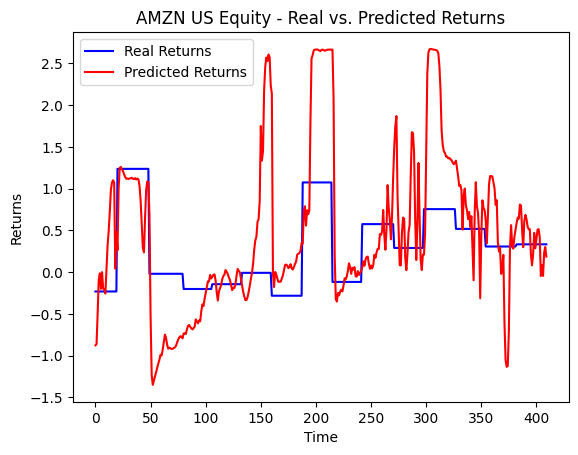

y vs y_pred: (316,) vs (316, 1)


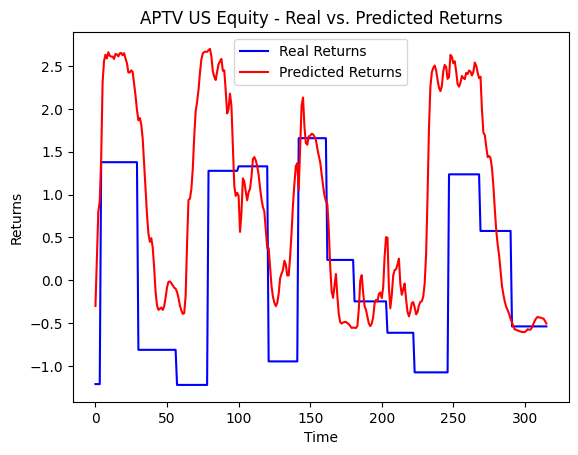

y vs y_pred: (314,) vs (314, 1)


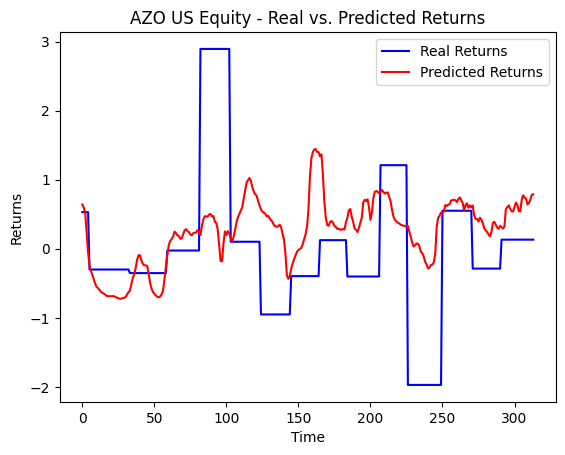

y vs y_pred: (324,) vs (324, 1)


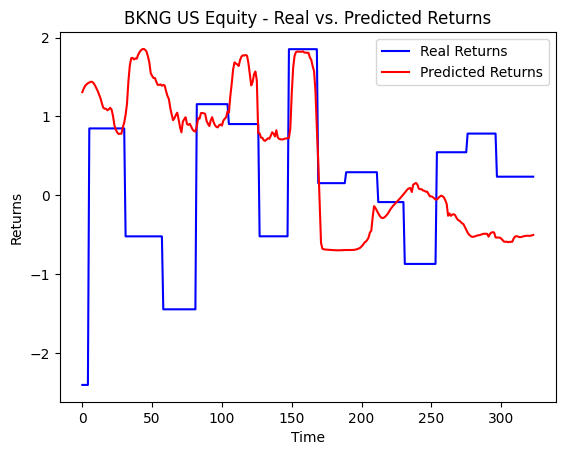

y vs y_pred: (314,) vs (314, 1)


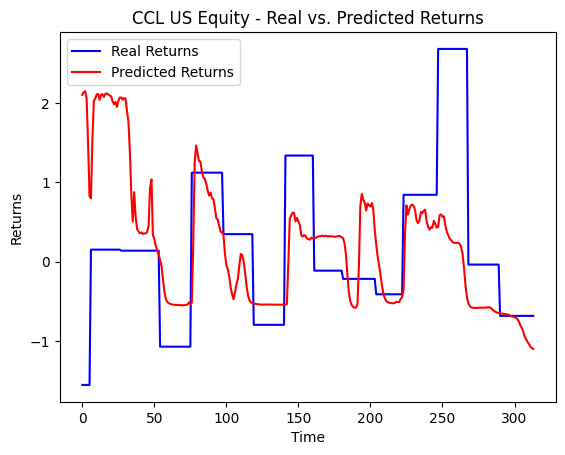

y vs y_pred: (325,) vs (325, 1)


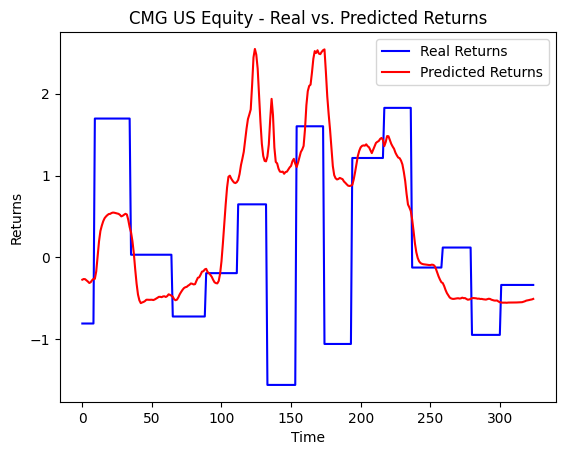

y vs y_pred: (306,) vs (306, 1)


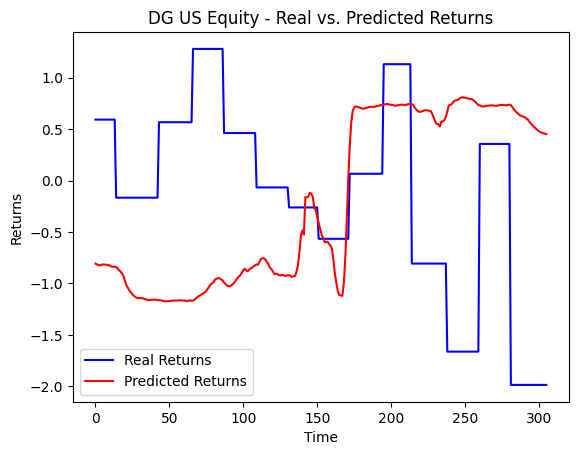

y vs y_pred: (325,) vs (325, 1)


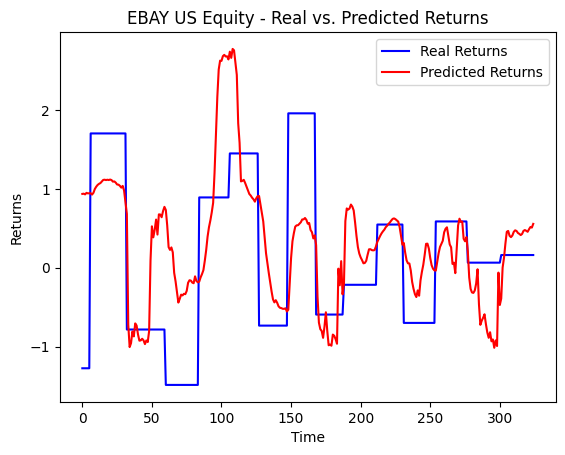

y vs y_pred: (394,) vs (394, 1)


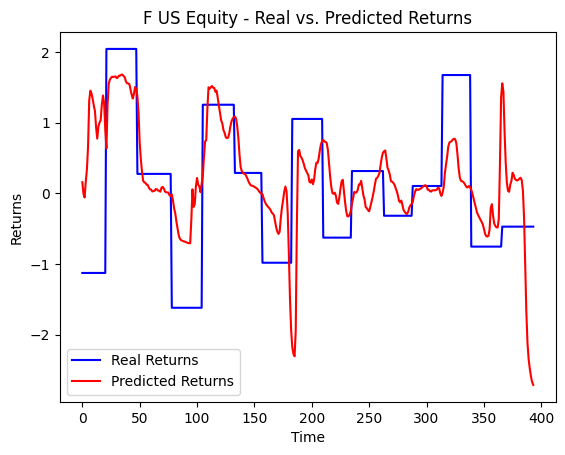

y vs y_pred: (418,) vs (418, 1)


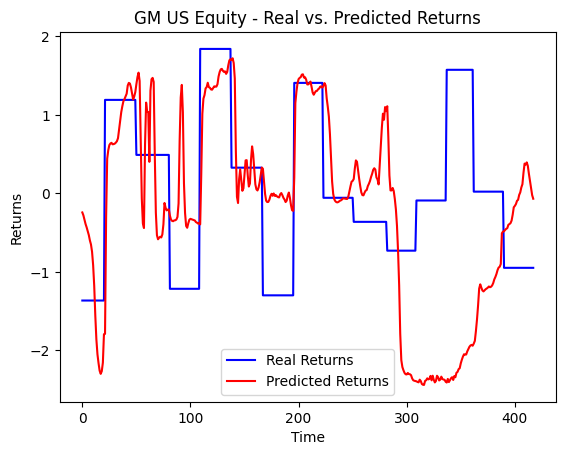

y vs y_pred: (330,) vs (330, 1)


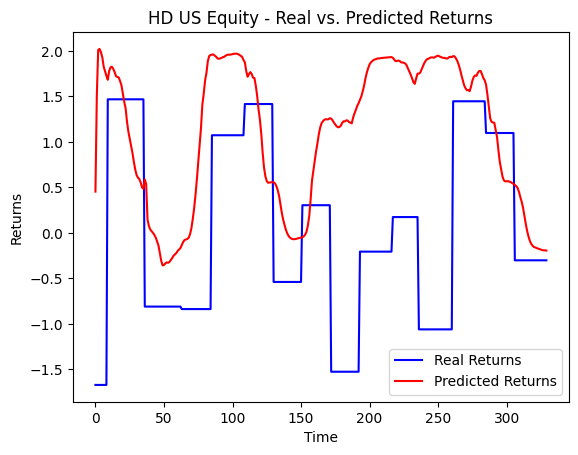

y vs y_pred: (317,) vs (317, 1)


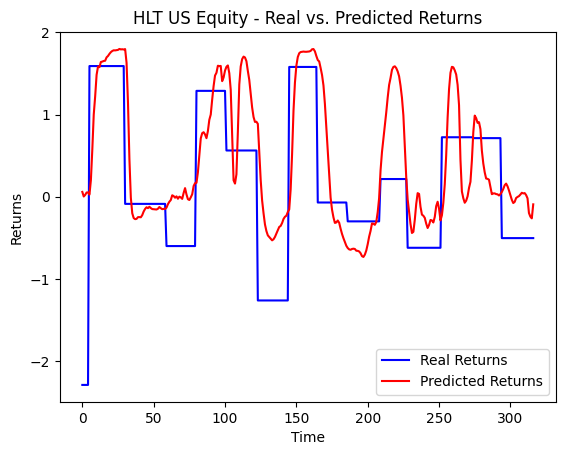

y vs y_pred: (325,) vs (325, 1)


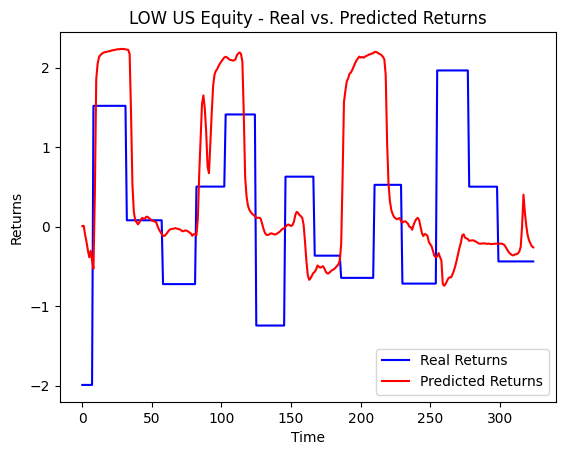

y vs y_pred: (324,) vs (324, 1)


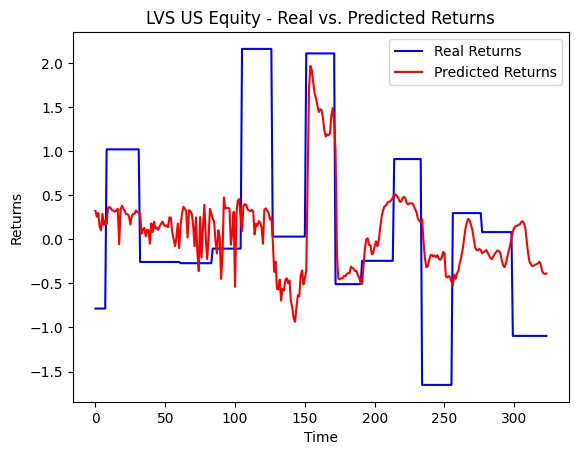

y vs y_pred: (341,) vs (341, 1)


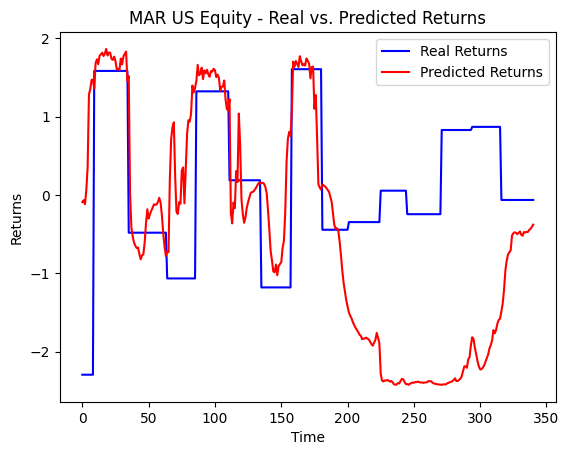

y vs y_pred: (336,) vs (336, 1)


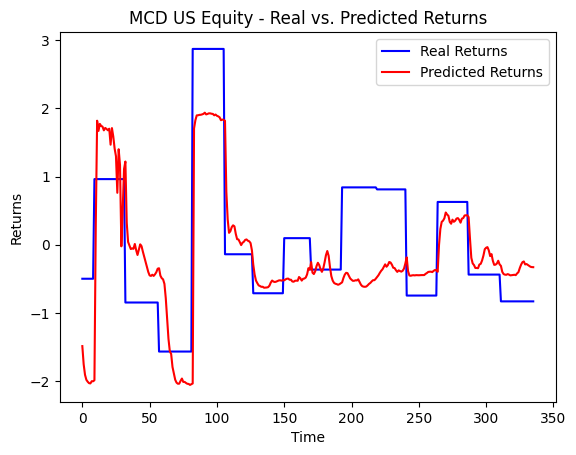

y vs y_pred: (346,) vs (346, 1)


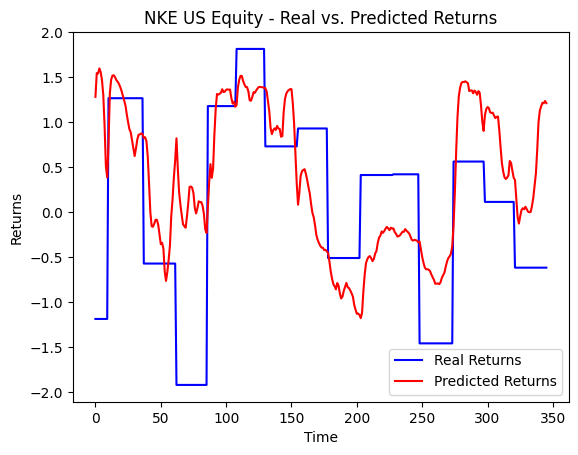

y vs y_pred: (316,) vs (316, 1)


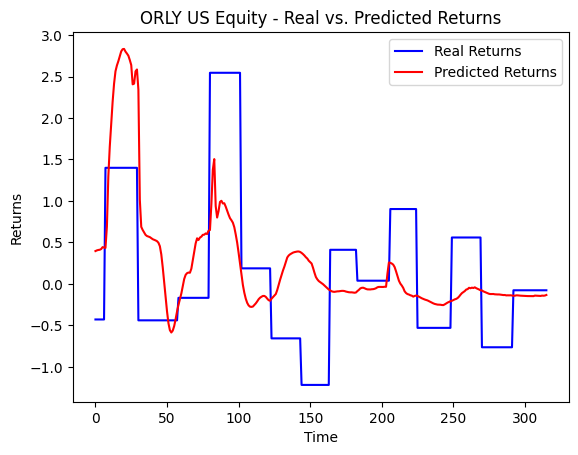

y vs y_pred: (319,) vs (319, 1)


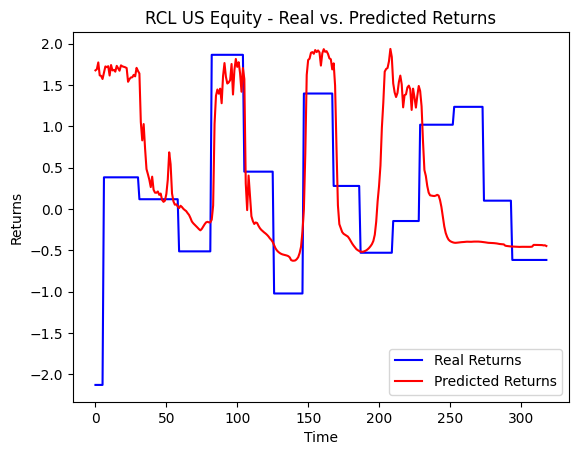

y vs y_pred: (322,) vs (322, 1)


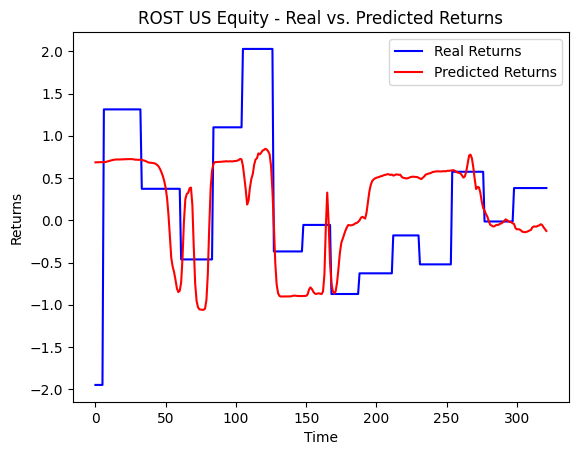

y vs y_pred: (348,) vs (348, 1)


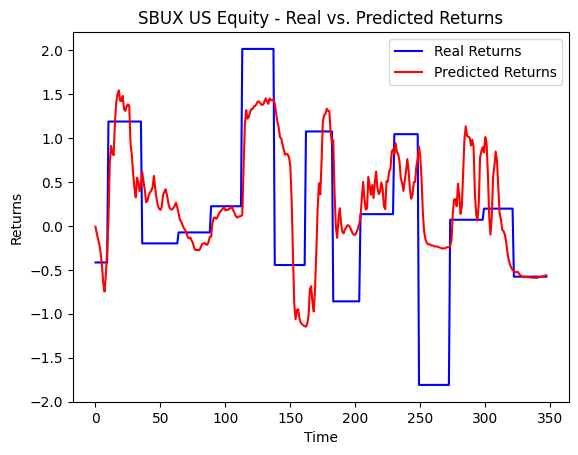

y vs y_pred: (321,) vs (321, 1)


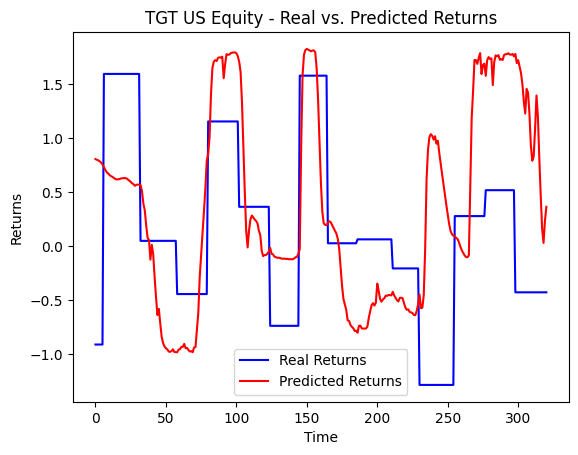

y vs y_pred: (318,) vs (318, 1)


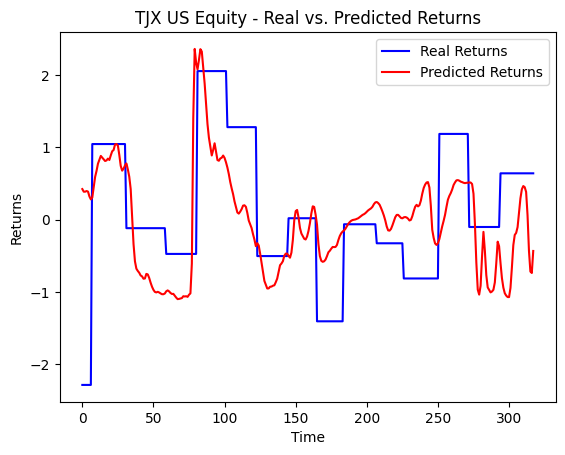

y vs y_pred: (321,) vs (321, 1)


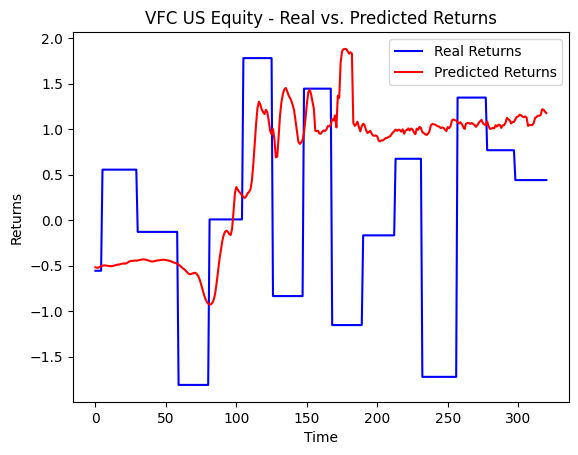

y vs y_pred: (347,) vs (347, 1)


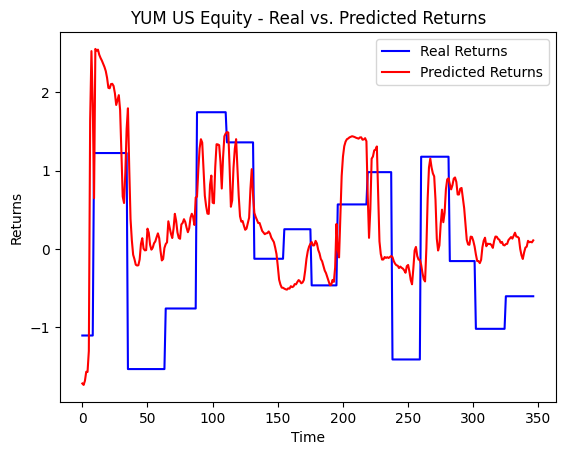

In [ ]:
pred25_cur = analyze(pred25_cur, TASK, mode)


In [ ]:
pred25_cur

AMZN US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -1.895311   
rmse                                                         0.790937   
mse                                                          0.625582   
y_preds             [[-0.87737453], [-0.8626188], [-0.4940746], [-...   
y                   [-0.23210444606497763, -0.23210444606497763, -...   

                                                       APTV US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -0.685661   
rmse                                                         1.330997   
mse                                                          1.771553   
y_preds             [[-0.30117223], [0.25151289], [0.80054784], [0...   
y                   [-1.2126143889412746, -1.2126143889412746, -1....   

                                                        AZO US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -0.070039   
rmse                                                         1.074781   
mse                                                          1.155153   
y_preds             [[0.6406368], [0.59638625], [0.5195588], [0.23...   
y                   [0.530100460540769, 0.530100460540769, 0.53010...   

                                                       BKNG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -0.932662   
rmse                                                         1.250413   
mse                                                          1.563532   
y_preds             [[1.3077075], [1.3514258], [1.387432], [1.4061...   
y                   [-2.4068948928092997, -2.4068948928092997, -2....   

                                                        CCL US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -0.246308   
rmse                                                         1.080807   
mse                                                          1.168143   
y_preds             [[2.1073415], [2.1411498], [2.1519003], [2.058...   
y                   [-1.5566849508933418, -1.5566849508933418, -1....   

                                                        CMG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -0.167364   
rmse                                                         1.111354   
mse                                                          1.235109   
y_preds             [[-0.27079588], [-0.26274896], [-0.26464796], ...   
y                   [-0.8058582084981688, -0.8058582084981688, -0....   

                                                         DG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -1.556047   
rmse                                                         1.466155   
mse                                                           2.14961   
y_preds             [[-0.8064202], [-0.81446016], [-0.822885], [-0...   
y                   [0.5931253049838197, 0.5931253049838197, 0.593...   

                                                       EBAY US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.214019   
rmse                                                         0.895278   
mse                                                          0.801522   
y_preds             [[0.936842], [0.93964535], [0.9309522], [0.950...   
y                   [-1.274460030

### One model all stock

In [ ]:
TASK = 'current'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1

mode = 'agg'

pred25_aggregate_cur = train_aggregate_model(train_df = dfall, val_df = df25, task = TASK, N_epoch = 30)

Epoch 1/30
339/339 [==============================] - ETA: 0s - loss: 0.3520
Epoch 1: val_loss improved from inf to 0.17977, saving model to weights_task_current_aggregate_model.h5
339/339 [==============================] - 25s 25ms/step - loss: 0.3520 - val_loss: 0.1798 - lr: 0.0100
Epoch 2/30
337/339 [============================>.] - ETA: 0s - loss: 0.1740
Epoch 2: val_loss improved from 0.17977 to 0.17069, saving model to weights_task_current_aggregate_model.h5
339/339 [==============================] - 6s 17ms/step - loss: 0.1747 - val_loss: 0.1707 - lr: 0.0100
Epoch 3/30
337/339 [============================>.] - ETA: 0s - loss: 0.1518
Epoch 3: val_loss did not improve from 0.17069
339/339 [==============================] - 7s 20ms/step - loss: 0.1515 - val_loss: 0.1776 - lr: 0.0100
Epoch 4/30
336/339 [============================>.] - ETA: 0s - loss: 0.1464
Epoch 4: val_loss improved from 0.17069 to 0.16861, saving model to weights_task_current_aggregate_model.h5
339/339 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




-------------------AMZN US Equity--------------------
13/13 [==============================] - 1s 7ms/step


-------------------APTV US Equity--------------------
10/10 [==============================] - 0s 7ms/step


-------------------AZO US Equity--------------------
10/10 [==============================] - 0s 6ms/step


-------------------BKNG US Equity--------------------
11/11 [==============================] - 0s 9ms/step


-------------------CCL US Equity--------------------
10/10 [==============================] - 0s 9ms/step


-------------------CMG US Equity--------------------
11/11 [==============================] - 0s 9ms/step


-------------------DG US Equity--------------------
10/10 [==============================] - 0s 9ms/step


-------------------EBAY US Equity--------------------
11/11 [==============================] - 0s 9ms/step


-------------------F US Equity--------------------
13/13 [==============================] - 0s 9ms/step


-------------------GM US 

y vs y_pred: (410,) vs (410, 1)


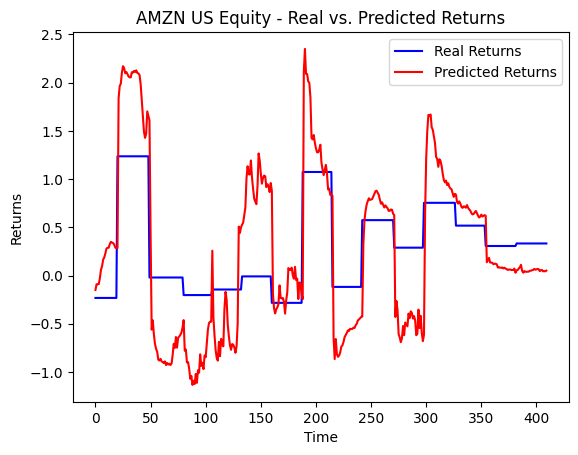

y vs y_pred: (316,) vs (316, 1)


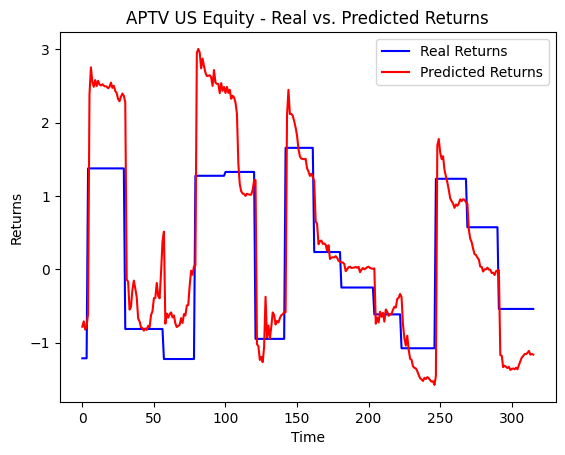

y vs y_pred: (314,) vs (314, 1)


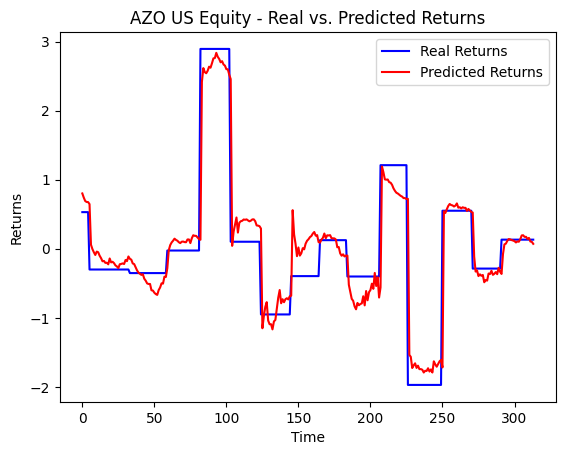

y vs y_pred: (324,) vs (324, 1)


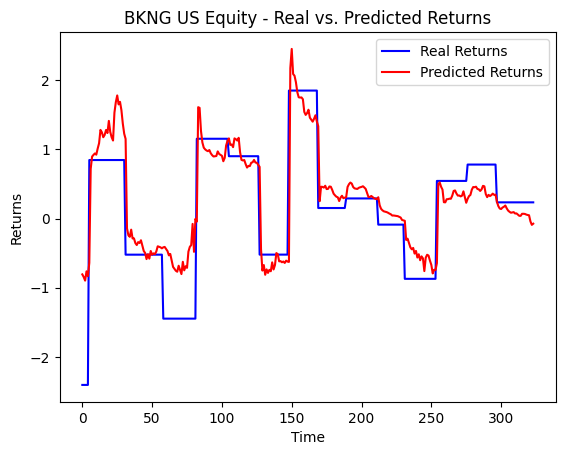

y vs y_pred: (314,) vs (314, 1)


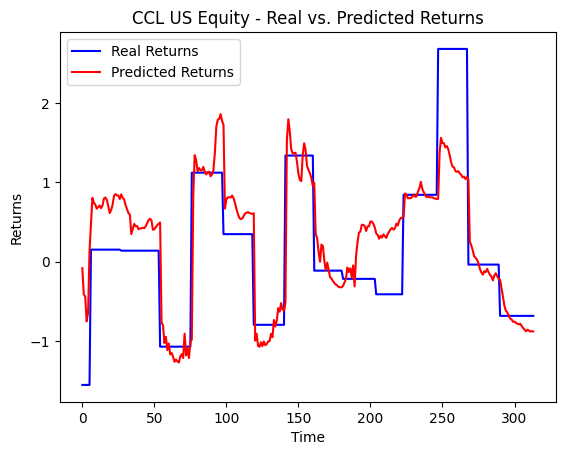

y vs y_pred: (325,) vs (325, 1)


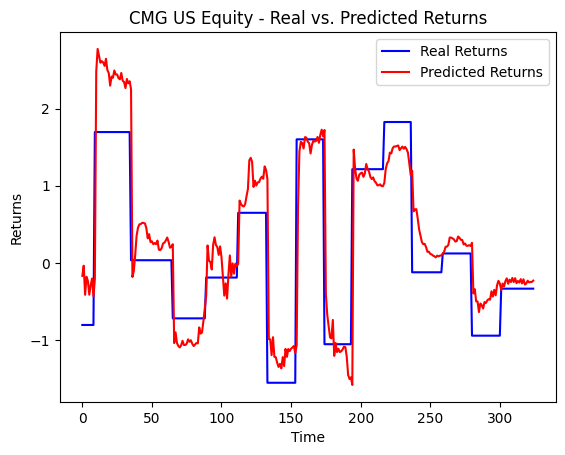

y vs y_pred: (306,) vs (306, 1)


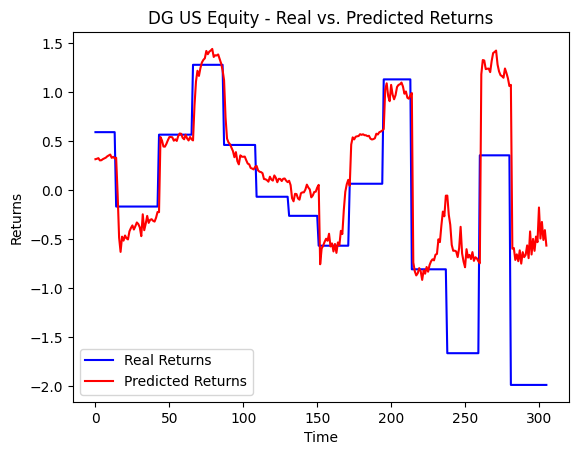

y vs y_pred: (325,) vs (325, 1)


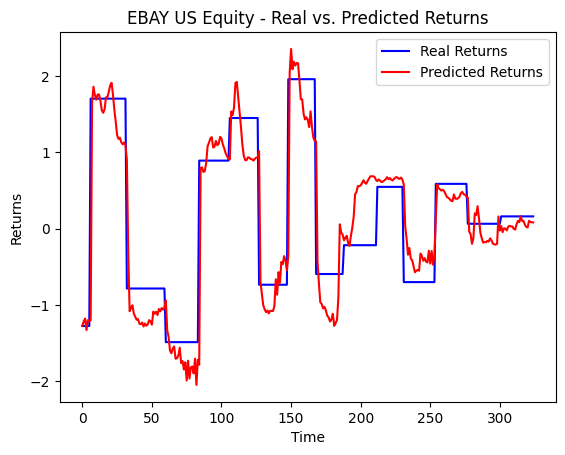

y vs y_pred: (394,) vs (394, 1)


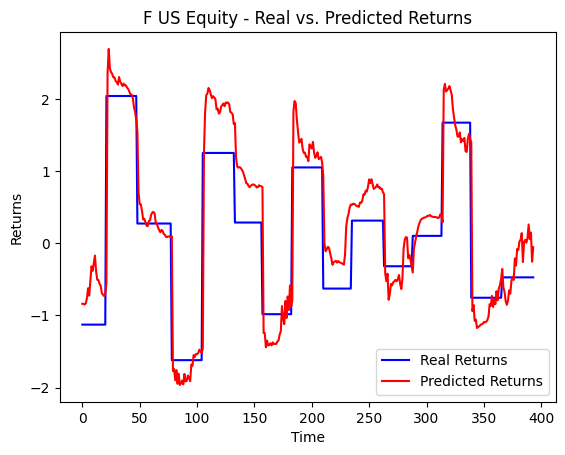

y vs y_pred: (418,) vs (418, 1)


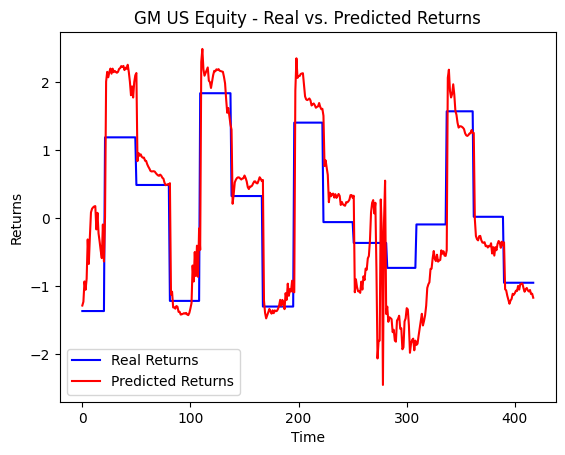

y vs y_pred: (330,) vs (330, 1)


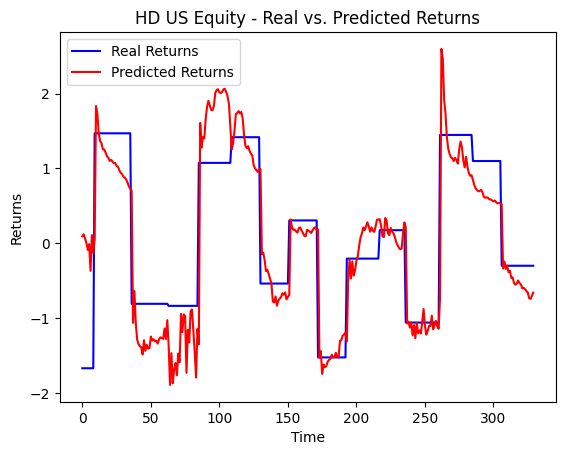

y vs y_pred: (317,) vs (317, 1)


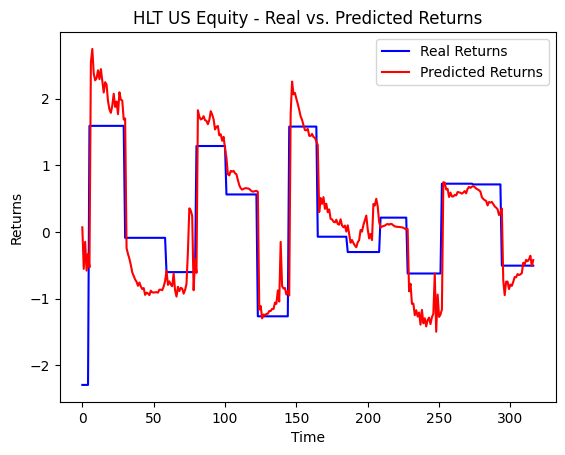

y vs y_pred: (325,) vs (325, 1)


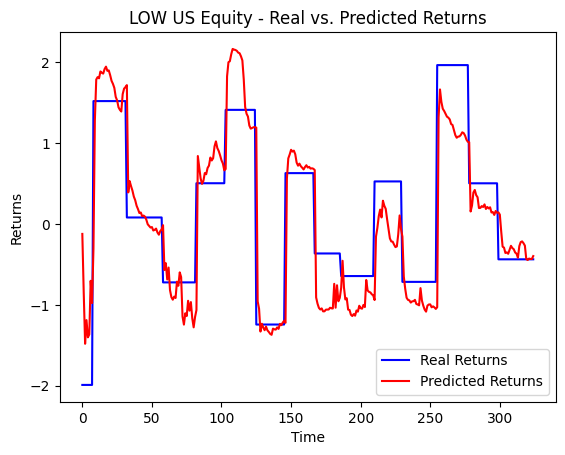

y vs y_pred: (324,) vs (324, 1)


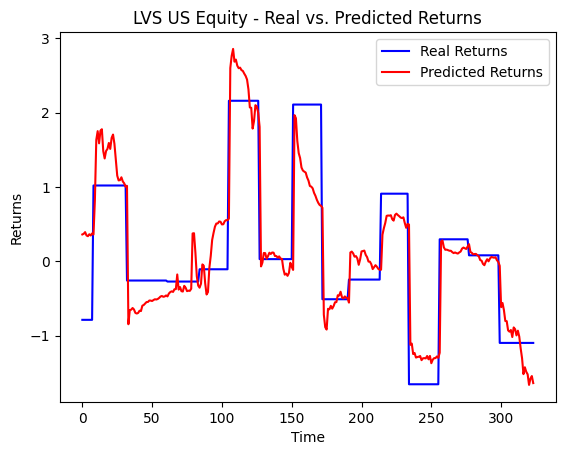

y vs y_pred: (341,) vs (341, 1)


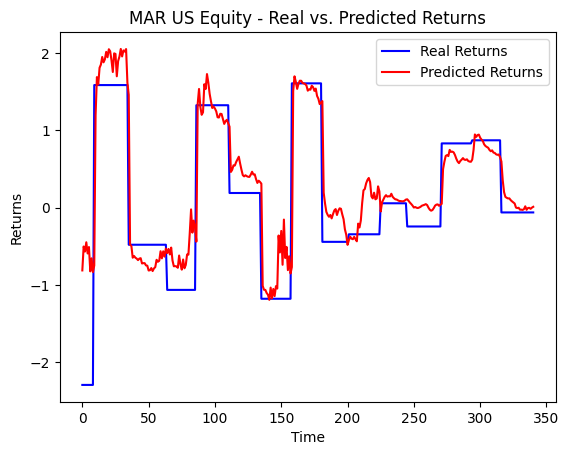

y vs y_pred: (336,) vs (336, 1)


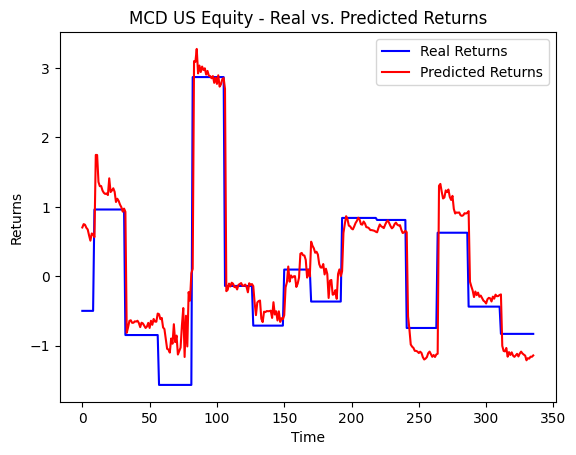

y vs y_pred: (346,) vs (346, 1)


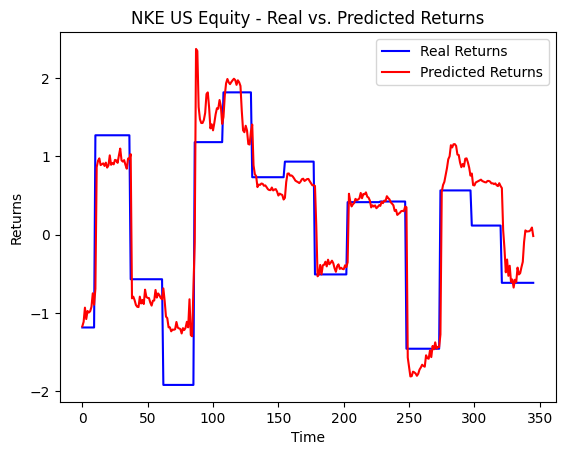

y vs y_pred: (316,) vs (316, 1)


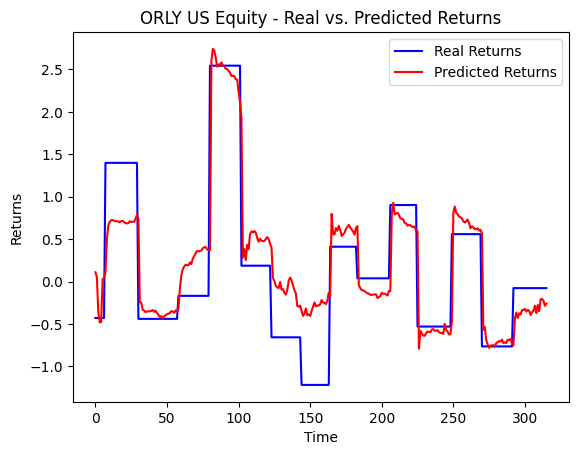

y vs y_pred: (319,) vs (319, 1)


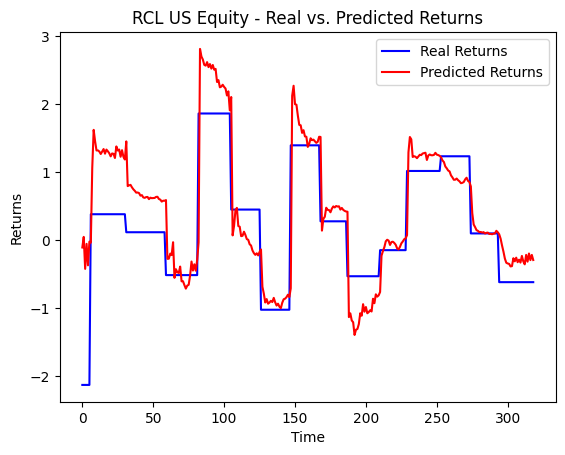

y vs y_pred: (322,) vs (322, 1)


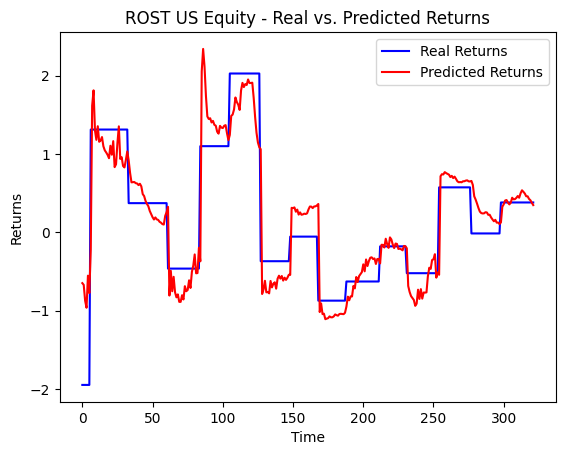

y vs y_pred: (348,) vs (348, 1)


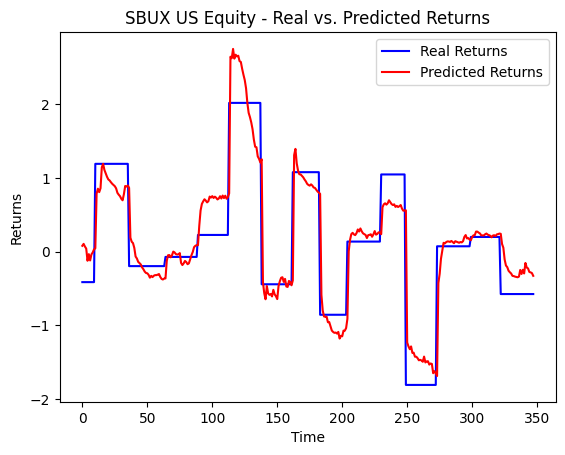

y vs y_pred: (321,) vs (321, 1)


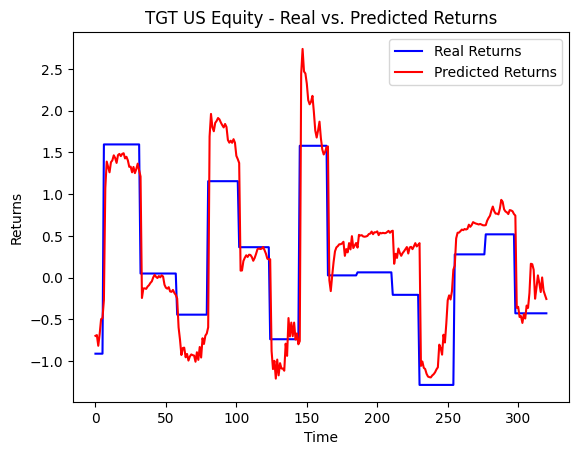

y vs y_pred: (318,) vs (318, 1)


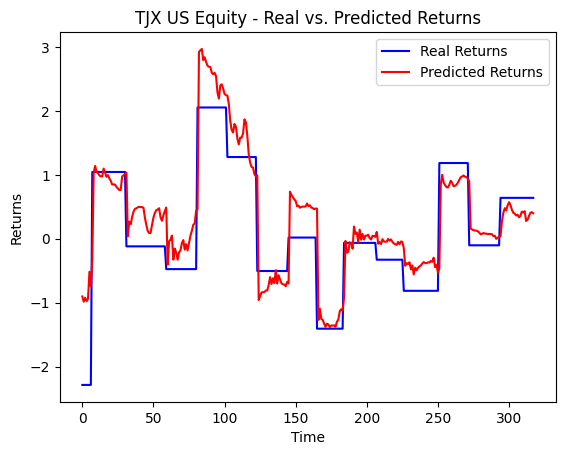

y vs y_pred: (321,) vs (321, 1)


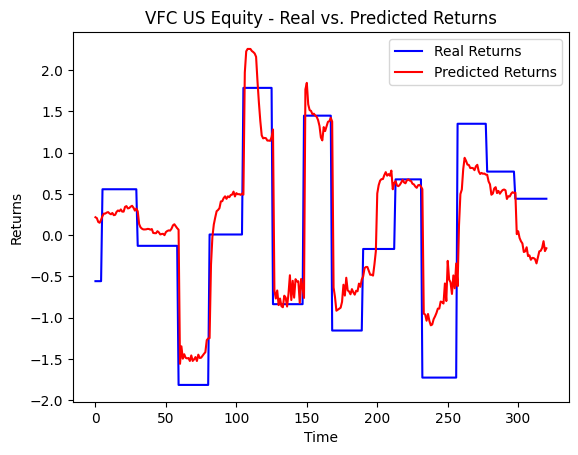

y vs y_pred: (347,) vs (347, 1)


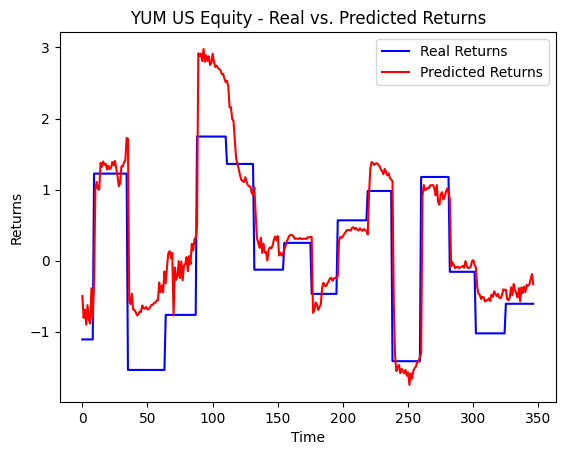

In [ ]:
pred25_aggregate_cur = analyze(pred25_aggregate_cur, TASK, mode)


In [ ]:
pred25_aggregate_cur

AMZN US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -0.549893   
rmse                                                         0.578689   
mse                                                          0.334881   
y_preds             [[-0.14936194], [-0.09014639], [-0.09040454], ...   
y                   [-0.23210444606497763, -0.23210444606497763, -...   

                                                       APTV US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                            0.50857   
rmse                                                         0.718659   
mse                                                          0.516471   
y_preds             [[-0.7814542], [-0.7082047], [-0.8217555], [-0...   
y                   [-1.2126143889412746, -1.2126143889412746, -1....   

                                                        AZO US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.851934   
rmse                                                         0.399805   
mse                                                          0.159844   
y_preds             [[0.8005897], [0.74116147], [0.69109464], [0.6...   
y                   [0.530100460540769, 0.530100460540769, 0.53010...   

                                                       BKNG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.726185   
rmse                                                         0.470656   
mse                                                          0.221517   
y_preds             [[-0.807415], [-0.845703], [-0.8975369], [-0.7...   
y                   [-2.4068948928092997, -2.4068948928092997, -2....   

                                                        CCL US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.626631   
rmse                                                         0.591568   
mse                                                          0.349953   
y_preds             [[-0.08253698], [-0.41163364], [-0.44029823], ...   
y                   [-1.5566849508933418, -1.5566849508933418, -1....   

                                                        CMG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.736545   
rmse                                                         0.527962   
mse                                                          0.278744   
y_preds             [[-0.16836497], [-0.037452977], [-0.41451052],...   
y                   [-0.8058582084981688, -0.8058582084981688, -0....   

                                                         DG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.527436   
rmse                                                         0.630414   
mse                                                          0.397422   
y_preds             [[0.317241], [0.32160416], [0.32785505], [0.30...   
y                   [0.5931253049838197, 0.5931253049838197, 0.593...   

                                                       EBAY US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.785479   
rmse                                                         0.467721   
mse                                                          0.218763   
y_preds             [[-1.2707767], [-1.213779], [-1.1762466], [-1....   
y                   [-1.274460030

## Task: predict 'MONTHLY_RETURN_F1'

In [ ]:
TASK = 'next'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1

### Separate model each stock

In [ ]:
stock25_next

In [ ]:
TASK = 'next'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1
mode = 'sep'
pred25_next = run_model(df25, TASK) # run 25 separate models and evaluate



-------------------AMZN US Equity--------------------
Epoch 1/30
16/17 [===========================>..] - ETA: 0s - loss: 1.1229
Epoch 1: val_loss improved from inf to 1.74258, saving model to weights_task_next_AMZN US Equity_model.h5
17/17 [==============================] - 9s 157ms/step - loss: 1.0965 - val_loss: 1.7426 - lr: 0.0100
Epoch 2/30
15/17 [=========================>....] - ETA: 0s - loss: 0.7655
Epoch 2: val_loss improved from 1.74258 to 1.67958, saving model to weights_task_next_AMZN US Equity_model.h5
17/17 [==============================] - 1s 30ms/step - loss: 0.7597 - val_loss: 1.6796 - lr: 0.0100
Epoch 3/30
16/17 [===========================>..] - ETA: 0s - loss: 0.5671
Epoch 3: val_loss did not improve from 1.67958
17/17 [==============================] - 0s 28ms/step - loss: 0.5534 - val_loss: 1.7643 - lr: 0.0100
Epoch 4/30
14/17 [=======================>......] - ETA: 0s - loss: 0.4723
Epoch 4: val_loss did not improve from 1.67958
17/17 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 1s 6ms/step


-------------------APTV US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.7612
Epoch 1: val_loss improved from inf to 1.32856, saving model to weights_task_next_APTV US Equity_model.h5
13/13 [==============================] - 9s 139ms/step - loss: 0.7612 - val_loss: 1.3286 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.2870
Epoch 2: val_loss improved from 1.32856 to 0.80299, saving model to weights_task_next_APTV US Equity_model.h5
13/13 [==============================] - 0s 23ms/step - loss: 0.2870 - val_loss: 0.8030 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.2214
Epoch 3: val_loss improved from 0.80299 to 0.55004, saving model to weights_task_next_APTV US Equity_model.h5
13/13 [==============================] - 0s 20ms/step - loss: 0.2214 - val_loss: 0.5500 - lr: 0.0100
Epoch 4/30
13/13 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 7ms/step


-------------------AZO US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.8830
Epoch 1: val_loss improved from inf to 1.64185, saving model to weights_task_next_AZO US Equity_model.h5
13/13 [==============================] - 9s 128ms/step - loss: 0.8830 - val_loss: 1.6419 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.3771
Epoch 2: val_loss improved from 1.64185 to 1.34736, saving model to weights_task_next_AZO US Equity_model.h5
13/13 [==============================] - 0s 20ms/step - loss: 0.3771 - val_loss: 1.3474 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.3182
Epoch 3: val_loss improved from 1.34736 to 1.12953, saving model to weights_task_next_AZO US Equity_model.h5
13/13 [==============================] - 0s 20ms/step - loss: 0.3182 - val_loss: 1.1295 - lr: 0.0100
Epoch 4/30
13/13 [======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 6ms/step


-------------------BKNG US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 1.3811
Epoch 1: val_loss improved from inf to 0.86642, saving model to weights_task_next_BKNG US Equity_model.h5
13/13 [==============================] - 10s 173ms/step - loss: 1.3811 - val_loss: 0.8664 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.6704
Epoch 2: val_loss did not improve from 0.86642
13/13 [==============================] - 0s 23ms/step - loss: 0.6704 - val_loss: 1.2021 - lr: 0.0100
Epoch 3/30
12/13 [==========================>...] - ETA: 0s - loss: 0.5639
Epoch 3: val_loss did not improve from 0.86642
13/13 [==============================] - 0s 23ms/step - loss: 0.5711 - val_loss: 0.9579 - lr: 0.0100
Epoch 4/30
12/13 [==========================>...] - ETA: 0s - loss: 0.5410
Epoch 4: val_loss did not improve from 0.86642
13/13 [==============================] 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 2s 10ms/step


-------------------CCL US Equity--------------------
Epoch 1/30
11/14 [======================>.......] - ETA: 0s - loss: 1.2100
Epoch 1: val_loss improved from inf to 0.38136, saving model to weights_task_next_CCL US Equity_model.h5
14/14 [==============================] - 8s 122ms/step - loss: 1.1008 - val_loss: 0.3814 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.5701
Epoch 2: val_loss did not improve from 0.38136
14/14 [==============================] - 0s 23ms/step - loss: 0.5674 - val_loss: 0.8371 - lr: 0.0100
Epoch 3/30
12/14 [========================>.....] - ETA: 0s - loss: 0.3749
Epoch 3: val_loss did not improve from 0.38136
14/14 [==============================] - 0s 22ms/step - loss: 0.3660 - val_loss: 0.6620 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.3013
Epoch 4: val_loss did not improve from 0.38136
14/14 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 6ms/step


-------------------CMG US Equity--------------------
Epoch 1/30
12/13 [==========================>...] - ETA: 0s - loss: 0.5981
Epoch 1: val_loss improved from inf to 0.64146, saving model to weights_task_next_CMG US Equity_model.h5
13/13 [==============================] - 11s 132ms/step - loss: 0.5848 - val_loss: 0.6415 - lr: 0.0100
Epoch 2/30
11/13 [========================>.....] - ETA: 0s - loss: 0.2803
Epoch 2: val_loss improved from 0.64146 to 0.57392, saving model to weights_task_next_CMG US Equity_model.h5
13/13 [==============================] - 0s 26ms/step - loss: 0.2749 - val_loss: 0.5739 - lr: 0.0100
Epoch 3/30
12/13 [==========================>...] - ETA: 0s - loss: 0.2367
Epoch 3: val_loss did not improve from 0.57392
13/13 [==============================] - 0s 24ms/step - loss: 0.2282 - val_loss: 0.6211 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.1833
Epoch 4: val_loss improved

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 7ms/step


-------------------DG US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.7198
Epoch 1: val_loss improved from inf to 1.95173, saving model to weights_task_next_DG US Equity_model.h5
13/13 [==============================] - 9s 133ms/step - loss: 0.7198 - val_loss: 1.9517 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.2838
Epoch 2: val_loss improved from 1.95173 to 1.81514, saving model to weights_task_next_DG US Equity_model.h5
13/13 [==============================] - 0s 21ms/step - loss: 0.2838 - val_loss: 1.8151 - lr: 0.0100
Epoch 3/30
12/13 [==========================>...] - ETA: 0s - loss: 0.2222
Epoch 3: val_loss improved from 1.81514 to 1.45083, saving model to weights_task_next_DG US Equity_model.h5
13/13 [==============================] - 0s 24ms/step - loss: 0.2154 - val_loss: 1.4508 - lr: 0.0100
Epoch 4/30
13/13 [==========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 7ms/step


-------------------EBAY US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 0.9194
Epoch 1: val_loss improved from inf to 2.28580, saving model to weights_task_next_EBAY US Equity_model.h5
14/14 [==============================] - 10s 191ms/step - loss: 0.9091 - val_loss: 2.2858 - lr: 0.0100
Epoch 2/30
12/14 [========================>.....] - ETA: 0s - loss: 0.5419
Epoch 2: val_loss improved from 2.28580 to 1.99896, saving model to weights_task_next_EBAY US Equity_model.h5
14/14 [==============================] - 0s 22ms/step - loss: 0.5229 - val_loss: 1.9990 - lr: 0.0100
Epoch 3/30
11/14 [======================>.......] - ETA: 0s - loss: 0.3549
Epoch 3: val_loss improved from 1.99896 to 1.50888, saving model to weights_task_next_EBAY US Equity_model.h5
14/14 [==============================] - 0s 26ms/step - loss: 0.3256 - val_loss: 1.5089 - lr: 0.0100
Epoch 4/30
13/14 [=================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 2s 9ms/step


-------------------F US Equity--------------------
Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 0.7154
Epoch 1: val_loss improved from inf to 1.18714, saving model to weights_task_next_F US Equity_model.h5
17/17 [==============================] - 9s 100ms/step - loss: 0.7154 - val_loss: 1.1871 - lr: 0.0100
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 0.2483
Epoch 2: val_loss improved from 1.18714 to 0.95878, saving model to weights_task_next_F US Equity_model.h5
17/17 [==============================] - 0s 21ms/step - loss: 0.2483 - val_loss: 0.9588 - lr: 0.0100
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.2040
Epoch 3: val_loss did not improve from 0.95878
17/17 [==============================] - 0s 19ms/step - loss: 0.2040 - val_loss: 1.4934 - lr: 0.0100
Epoch 4/30
17/17 [==============================] - ETA: 0s - loss: 0.1353
Epoch 4: val_loss did not improve

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 1s 6ms/step


-------------------GM US Equity--------------------
Epoch 1/30
16/18 [=========================>....] - ETA: 0s - loss: 1.0147
Epoch 1: val_loss improved from inf to 0.72455, saving model to weights_task_next_GM US Equity_model.h5
18/18 [==============================] - 10s 151ms/step - loss: 0.9832 - val_loss: 0.7246 - lr: 0.0100
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.5677
Epoch 2: val_loss did not improve from 0.72455
18/18 [==============================] - 0s 25ms/step - loss: 0.5677 - val_loss: 1.0773 - lr: 0.0100
Epoch 3/30
15/18 [========================>.....] - ETA: 0s - loss: 0.5062
Epoch 3: val_loss did not improve from 0.72455
18/18 [==============================] - 0s 22ms/step - loss: 0.5031 - val_loss: 1.1608 - lr: 0.0100
Epoch 4/30
16/18 [=========================>....] - ETA: 0s - loss: 0.4191
Epoch 4: val_loss did not improve from 0.72455
18/18 [==============================] - 0s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 6ms/step


-------------------HD US Equity--------------------
Epoch 1/30
12/13 [==========================>...] - ETA: 0s - loss: 0.7935
Epoch 1: val_loss improved from inf to 2.98139, saving model to weights_task_next_HD US Equity_model.h5
13/13 [==============================] - 10s 134ms/step - loss: 0.7530 - val_loss: 2.9814 - lr: 0.0100
Epoch 2/30
11/13 [========================>.....] - ETA: 0s - loss: 0.2872
Epoch 2: val_loss did not improve from 2.98139
13/13 [==============================] - 0s 24ms/step - loss: 0.2846 - val_loss: 3.3727 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.2731
Epoch 3: val_loss did not improve from 2.98139
13/13 [==============================] - 0s 20ms/step - loss: 0.2731 - val_loss: 3.9234 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.2358
Epoch 4: val_loss did not improve from 2.98139
13/13 [==============================] - 0s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 7ms/step


-------------------HLT US Equity--------------------
Epoch 1/30
12/14 [========================>.....] - ETA: 0s - loss: 0.8533
Epoch 1: val_loss improved from inf to 0.52620, saving model to weights_task_next_HLT US Equity_model.h5
14/14 [==============================] - 8s 148ms/step - loss: 0.8457 - val_loss: 0.5262 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.7379
Epoch 2: val_loss improved from 0.52620 to 0.49943, saving model to weights_task_next_HLT US Equity_model.h5
14/14 [==============================] - 0s 32ms/step - loss: 0.7353 - val_loss: 0.4994 - lr: 0.0100
Epoch 3/30
12/14 [========================>.....] - ETA: 0s - loss: 0.6237
Epoch 3: val_loss did not improve from 0.49943
14/14 [==============================] - 0s 30ms/step - loss: 0.6273 - val_loss: 0.6472 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.6852
Epoch 4: val_loss improved 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 7ms/step


-------------------LOW US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 0.7455
Epoch 1: val_loss improved from inf to 2.23999, saving model to weights_task_next_LOW US Equity_model.h5
14/14 [==============================] - 11s 210ms/step - loss: 0.7443 - val_loss: 2.2400 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.3257
Epoch 2: val_loss improved from 2.23999 to 1.62714, saving model to weights_task_next_LOW US Equity_model.h5
14/14 [==============================] - 0s 23ms/step - loss: 0.3251 - val_loss: 1.6271 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2605
Epoch 3: val_loss improved from 1.62714 to 0.91902, saving model to weights_task_next_LOW US Equity_model.h5
14/14 [==============================] - 0s 21ms/step - loss: 0.2599 - val_loss: 0.9190 - lr: 0.0100
Epoch 4/30
11/14 [=====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 7ms/step


-------------------LVS US Equity--------------------
Epoch 1/30
11/13 [========================>.....] - ETA: 0s - loss: 1.3882
Epoch 1: val_loss improved from inf to 0.67971, saving model to weights_task_next_LVS US Equity_model.h5
13/13 [==============================] - 9s 130ms/step - loss: 1.2951 - val_loss: 0.6797 - lr: 0.0100
Epoch 2/30
12/13 [==========================>...] - ETA: 0s - loss: 0.7311
Epoch 2: val_loss improved from 0.67971 to 0.61281, saving model to weights_task_next_LVS US Equity_model.h5
13/13 [==============================] - 0s 23ms/step - loss: 0.7425 - val_loss: 0.6128 - lr: 0.0100
Epoch 3/30
12/13 [==========================>...] - ETA: 0s - loss: 0.6844
Epoch 3: val_loss did not improve from 0.61281
13/13 [==============================] - 0s 21ms/step - loss: 0.6682 - val_loss: 0.6876 - lr: 0.0100
Epoch 4/30
12/13 [==========================>...] - ETA: 0s - loss: 0.5934
Epoch 4: val_loss did not i

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 7ms/step


-------------------MAR US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 1.3861
Epoch 1: val_loss improved from inf to 0.23244, saving model to weights_task_next_MAR US Equity_model.h5
14/14 [==============================] - 9s 189ms/step - loss: 1.3573 - val_loss: 0.2324 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.7252
Epoch 2: val_loss did not improve from 0.23244
14/14 [==============================] - 0s 28ms/step - loss: 0.7332 - val_loss: 0.3645 - lr: 0.0100
Epoch 3/30
12/14 [========================>.....] - ETA: 0s - loss: 0.6104
Epoch 3: val_loss did not improve from 0.23244
14/14 [==============================] - 0s 31ms/step - loss: 0.6226 - val_loss: 0.4170 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.6110
Epoch 4: val_loss did not improve from 0.23244
14/14 [==============================] - 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 7ms/step


-------------------MCD US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 0.7202
Epoch 1: val_loss improved from inf to 0.87764, saving model to weights_task_next_MCD US Equity_model.h5
14/14 [==============================] - 9s 121ms/step - loss: 0.7001 - val_loss: 0.8776 - lr: 0.0100
Epoch 2/30
12/14 [========================>.....] - ETA: 0s - loss: 0.2697
Epoch 2: val_loss improved from 0.87764 to 0.80714, saving model to weights_task_next_MCD US Equity_model.h5
14/14 [==============================] - 0s 26ms/step - loss: 0.2946 - val_loss: 0.8071 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2132
Epoch 3: val_loss did not improve from 0.80714
14/14 [==============================] - 0s 22ms/step - loss: 0.2168 - val_loss: 0.8257 - lr: 0.0100
Epoch 4/30
12/14 [========================>.....] - ETA: 0s - loss: 0.1800
Epoch 4: val_loss did not i

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 3s 10ms/step


-------------------NKE US Equity--------------------
Epoch 1/30
12/14 [========================>.....] - ETA: 0s - loss: 0.9698
Epoch 1: val_loss improved from inf to 0.31860, saving model to weights_task_next_NKE US Equity_model.h5
14/14 [==============================] - 9s 125ms/step - loss: 0.9615 - val_loss: 0.3186 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.6119
Epoch 2: val_loss did not improve from 0.31860
14/14 [==============================] - 0s 22ms/step - loss: 0.6079 - val_loss: 3.2595 - lr: 0.0100
Epoch 3/30
12/14 [========================>.....] - ETA: 0s - loss: 0.4080
Epoch 3: val_loss did not improve from 0.31860
14/14 [==============================] - 0s 20ms/step - loss: 0.4032 - val_loss: 3.4492 - lr: 0.0100
Epoch 4/30
14/14 [==============================] - ETA: 0s - loss: 0.4811
Epoch 4: val_loss did not improve from 0.31860
14/14 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 7ms/step


-------------------ORLY US Equity--------------------
Epoch 1/30
12/13 [==========================>...] - ETA: 0s - loss: 0.4987
Epoch 1: val_loss improved from inf to 0.93380, saving model to weights_task_next_ORLY US Equity_model.h5
13/13 [==============================] - 10s 174ms/step - loss: 0.4775 - val_loss: 0.9338 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.2518
Epoch 2: val_loss did not improve from 0.93380
13/13 [==============================] - 0s 20ms/step - loss: 0.2518 - val_loss: 0.9781 - lr: 0.0100
Epoch 3/30
12/13 [==========================>...] - ETA: 0s - loss: 0.2064
Epoch 3: val_loss did not improve from 0.93380
13/13 [==============================] - 0s 24ms/step - loss: 0.2127 - val_loss: 1.0930 - lr: 0.0100
Epoch 4/30
12/13 [==========================>...] - ETA: 0s - loss: 0.2147
Epoch 4: val_loss did not improve from 0.93380
13/13 [==============================] 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 7ms/step


-------------------RCL US Equity--------------------
Epoch 1/30
12/13 [==========================>...] - ETA: 0s - loss: 0.9327
Epoch 1: val_loss improved from inf to 0.15551, saving model to weights_task_next_RCL US Equity_model.h5
13/13 [==============================] - 9s 136ms/step - loss: 0.9071 - val_loss: 0.1555 - lr: 0.0100
Epoch 2/30
11/13 [========================>.....] - ETA: 0s - loss: 0.4593
Epoch 2: val_loss did not improve from 0.15551
13/13 [==============================] - 0s 25ms/step - loss: 0.4412 - val_loss: 0.1791 - lr: 0.0100
Epoch 3/30
12/13 [==========================>...] - ETA: 0s - loss: 0.3046
Epoch 3: val_loss improved from 0.15551 to 0.09509, saving model to weights_task_next_RCL US Equity_model.h5
13/13 [==============================] - 0s 25ms/step - loss: 0.2977 - val_loss: 0.0951 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.3691
Epoch 4: val_loss did not i

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 8ms/step


-------------------ROST US Equity--------------------
Epoch 1/30
12/13 [==========================>...] - ETA: 0s - loss: 1.2045
Epoch 1: val_loss improved from inf to 0.73039, saving model to weights_task_next_ROST US Equity_model.h5
13/13 [==============================] - 11s 133ms/step - loss: 1.1690 - val_loss: 0.7304 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.8905
Epoch 2: val_loss improved from 0.73039 to 0.70442, saving model to weights_task_next_ROST US Equity_model.h5
13/13 [==============================] - 0s 21ms/step - loss: 0.8905 - val_loss: 0.7044 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.8105
Epoch 3: val_loss improved from 0.70442 to 0.58205, saving model to weights_task_next_ROST US Equity_model.h5
13/13 [==============================] - 0s 22ms/step - loss: 0.8105 - val_loss: 0.5820 - lr: 0.0100
Epoch 4/30
13/13 [=================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 2s 7ms/step


-------------------SBUX US Equity--------------------
Epoch 1/30
12/14 [========================>.....] - ETA: 0s - loss: 0.7034
Epoch 1: val_loss improved from inf to 3.42391, saving model to weights_task_next_SBUX US Equity_model.h5
14/14 [==============================] - 8s 135ms/step - loss: 0.6704 - val_loss: 3.4239 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.4448
Epoch 2: val_loss did not improve from 3.42391
14/14 [==============================] - 0s 28ms/step - loss: 0.4360 - val_loss: 4.5998 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.3612
Epoch 3: val_loss did not improve from 3.42391
14/14 [==============================] - 0s 27ms/step - loss: 0.3540 - val_loss: 3.8283 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2552
Epoch 4: val_loss did not improve from 3.42391
14/14 [==============================] -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 7ms/step


-------------------TGT US Equity--------------------
Epoch 1/30
12/14 [========================>.....] - ETA: 0s - loss: 1.2593
Epoch 1: val_loss improved from inf to 1.03074, saving model to weights_task_next_TGT US Equity_model.h5
14/14 [==============================] - 10s 124ms/step - loss: 1.1949 - val_loss: 1.0307 - lr: 0.0100
Epoch 2/30
11/14 [======================>.......] - ETA: 0s - loss: 0.7581
Epoch 2: val_loss did not improve from 1.03074
14/14 [==============================] - 0s 24ms/step - loss: 0.7513 - val_loss: 1.0726 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.5448
Epoch 3: val_loss did not improve from 1.03074
14/14 [==============================] - 0s 20ms/step - loss: 0.5447 - val_loss: 1.6495 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.4939
Epoch 4: val_loss improved from 1.03074 to 0.44972, saving model to weights_task_next_TG

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 7ms/step


-------------------TJX US Equity--------------------
Epoch 1/30
11/13 [========================>.....] - ETA: 0s - loss: 1.0780
Epoch 1: val_loss improved from inf to 1.13042, saving model to weights_task_next_TJX US Equity_model.h5
13/13 [==============================] - 9s 133ms/step - loss: 1.0724 - val_loss: 1.1304 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.6735
Epoch 2: val_loss improved from 1.13042 to 0.77921, saving model to weights_task_next_TJX US Equity_model.h5
13/13 [==============================] - 0s 24ms/step - loss: 0.6735 - val_loss: 0.7792 - lr: 0.0100
Epoch 3/30
11/13 [========================>.....] - ETA: 0s - loss: 0.5320
Epoch 3: val_loss did not improve from 0.77921
13/13 [==============================] - 0s 22ms/step - loss: 0.5401 - val_loss: 1.1117 - lr: 0.0100
Epoch 4/30
12/13 [==========================>...] - ETA: 0s - loss: 0.4559
Epoch 4: val_loss did not i

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 7ms/step


-------------------VFC US Equity--------------------
Epoch 1/30
10/13 [======================>.......] - ETA: 0s - loss: 0.9707
Epoch 1: val_loss improved from inf to 1.07581, saving model to weights_task_next_VFC US Equity_model.h5
13/13 [==============================] - 11s 137ms/step - loss: 0.9170 - val_loss: 1.0758 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.5577
Epoch 2: val_loss improved from 1.07581 to 0.66588, saving model to weights_task_next_VFC US Equity_model.h5
13/13 [==============================] - 0s 25ms/step - loss: 0.5577 - val_loss: 0.6659 - lr: 0.0100
Epoch 3/30
11/13 [========================>.....] - ETA: 0s - loss: 0.4717
Epoch 3: val_loss improved from 0.66588 to 0.64533, saving model to weights_task_next_VFC US Equity_model.h5
13/13 [==============================] - 0s 23ms/step - loss: 0.4631 - val_loss: 0.6453 - lr: 0.0100
Epoch 4/30
13/13 [=====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 2s 7ms/step


-------------------YUM US Equity--------------------
Epoch 1/30
11/14 [======================>.......] - ETA: 0s - loss: 0.9547
Epoch 1: val_loss improved from inf to 0.57648, saving model to weights_task_next_YUM US Equity_model.h5
14/14 [==============================] - 9s 152ms/step - loss: 0.8419 - val_loss: 0.5765 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.3023
Epoch 2: val_loss did not improve from 0.57648
14/14 [==============================] - 0s 30ms/step - loss: 0.2981 - val_loss: 0.6602 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2359
Epoch 3: val_loss did not improve from 0.57648
14/14 [==============================] - 0s 29ms/step - loss: 0.2313 - val_loss: 0.6596 - lr: 0.0100
Epoch 4/30
12/14 [========================>.....] - ETA: 0s - loss: 0.2275
Epoch 4: val_loss did not improve from 0.57648
14/14 [==============================] - 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 7ms/step


y vs y_pred: (410,) vs (410, 1)


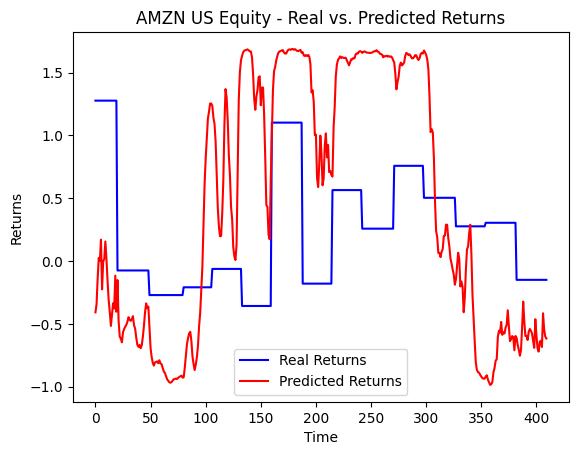

y vs y_pred: (316,) vs (316, 1)


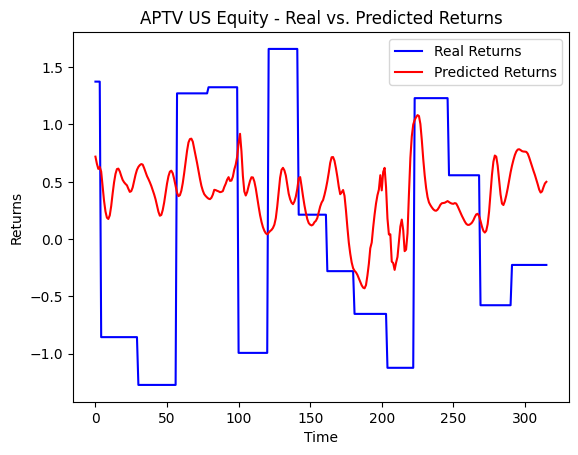

y vs y_pred: (314,) vs (314, 1)


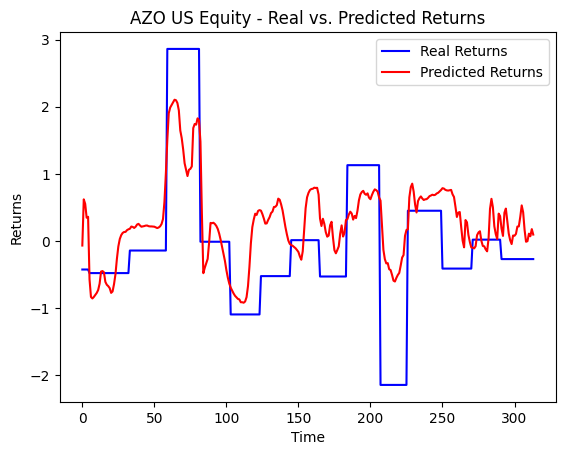

y vs y_pred: (324,) vs (324, 1)


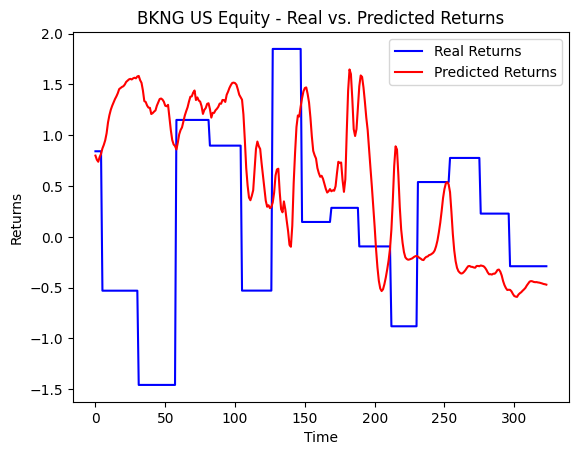

y vs y_pred: (314,) vs (314, 1)


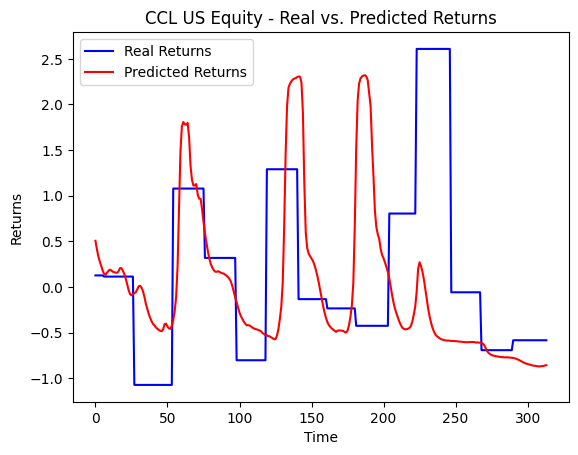

y vs y_pred: (325,) vs (325, 1)


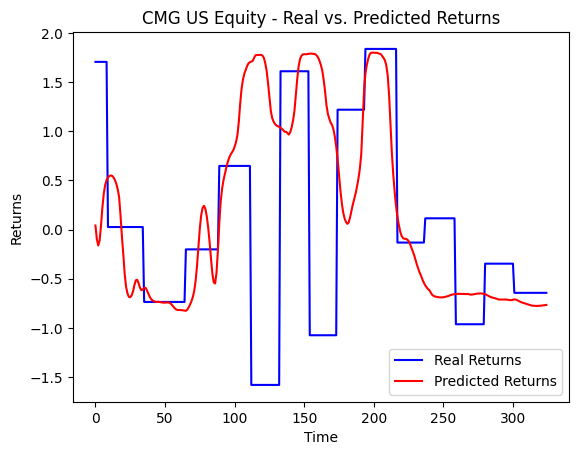

y vs y_pred: (306,) vs (306, 1)


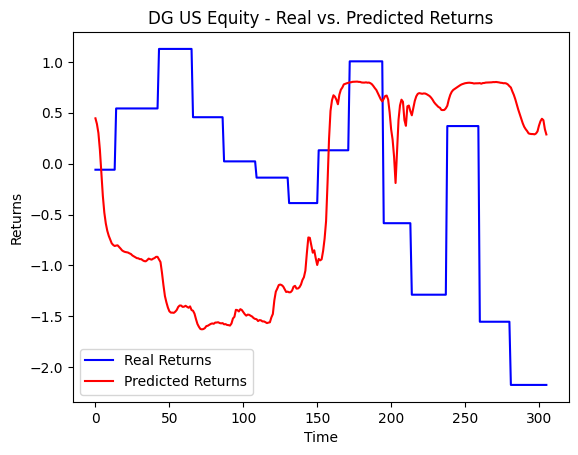

y vs y_pred: (325,) vs (325, 1)


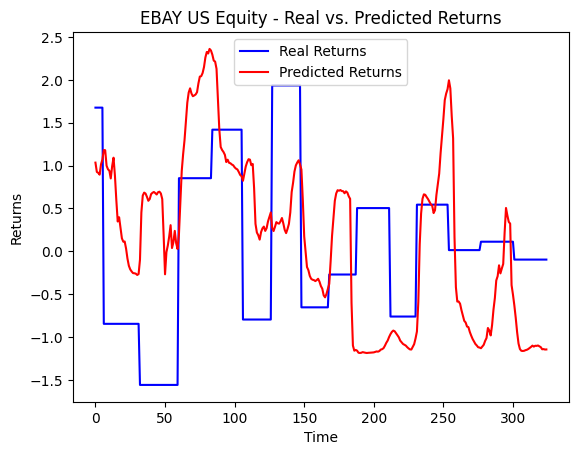

y vs y_pred: (394,) vs (394, 1)


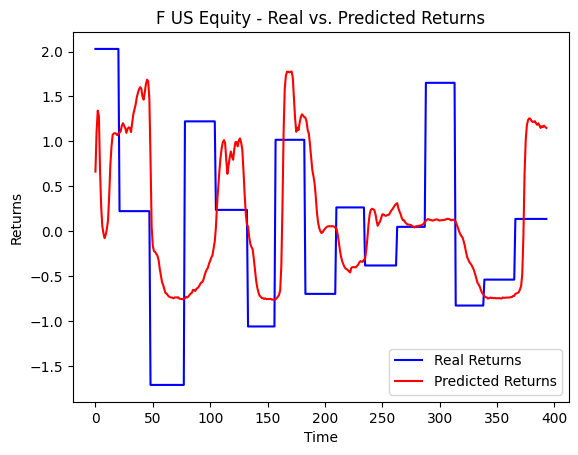

y vs y_pred: (418,) vs (418, 1)


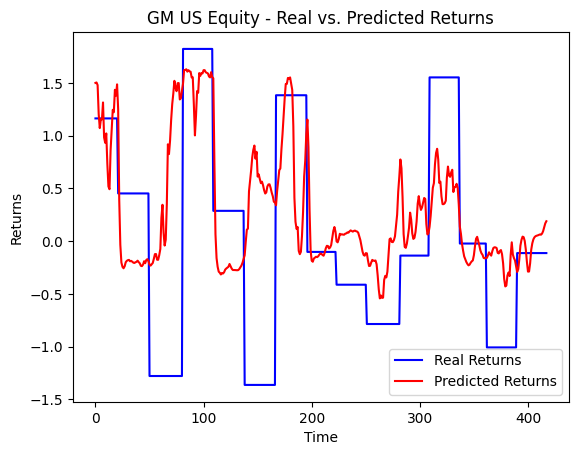

y vs y_pred: (330,) vs (330, 1)


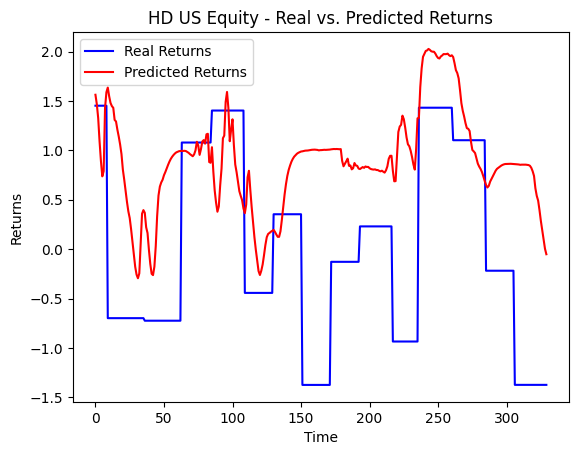

y vs y_pred: (317,) vs (317, 1)


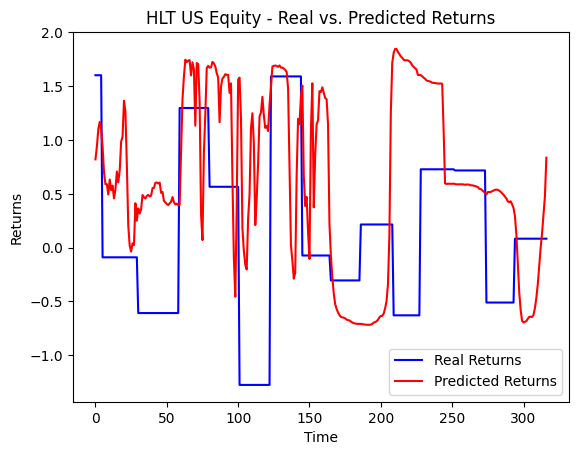

y vs y_pred: (325,) vs (325, 1)


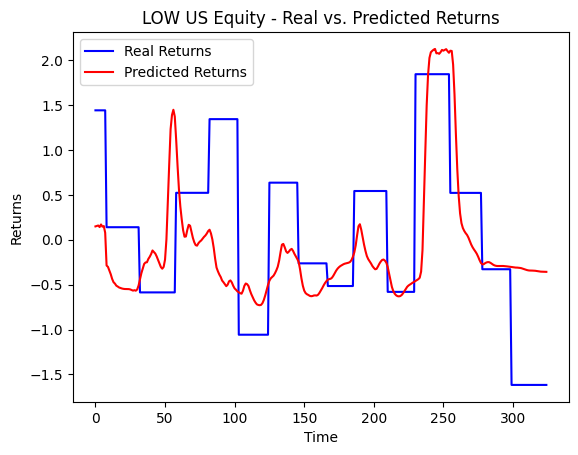

y vs y_pred: (324,) vs (324, 1)


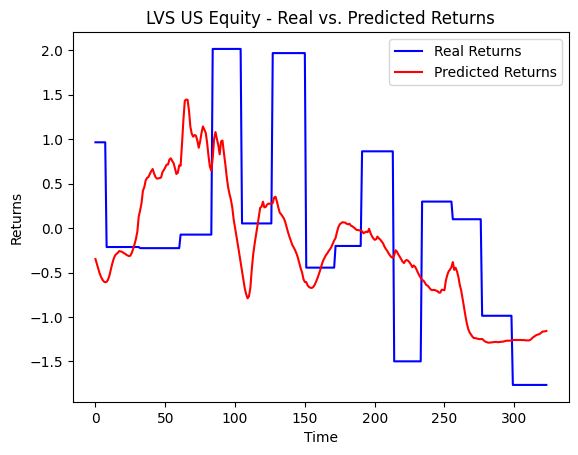

y vs y_pred: (341,) vs (341, 1)


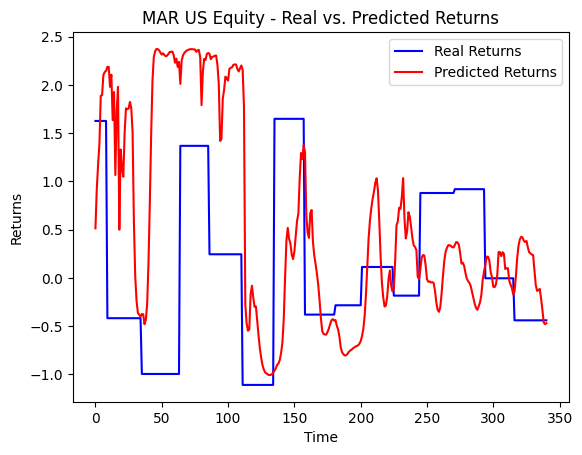

y vs y_pred: (336,) vs (336, 1)


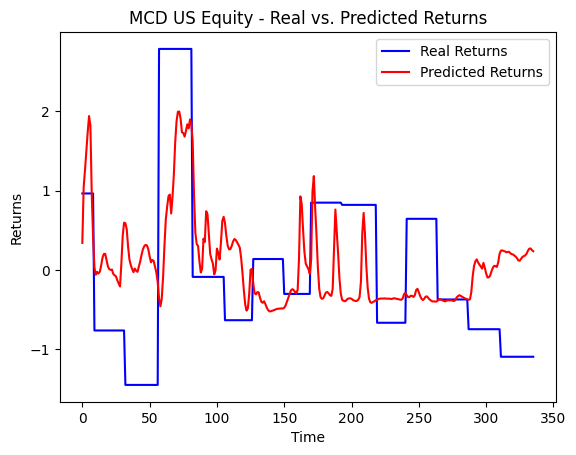

y vs y_pred: (346,) vs (346, 1)


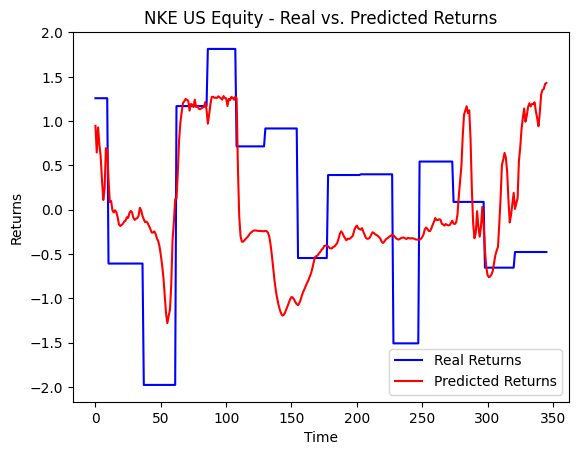

y vs y_pred: (316,) vs (316, 1)


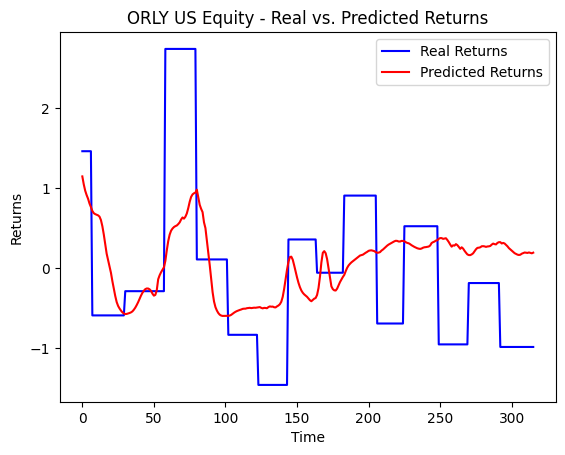

y vs y_pred: (319,) vs (319, 1)


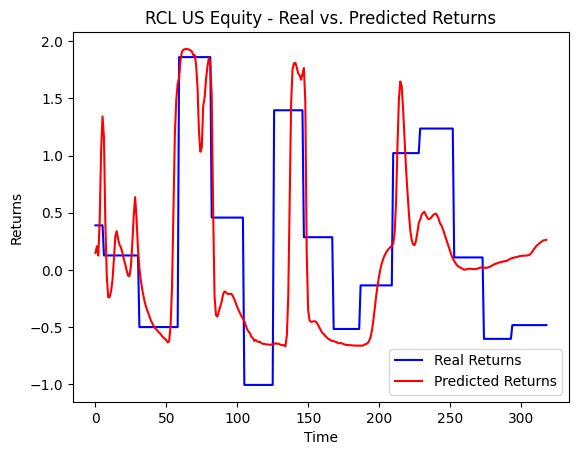

y vs y_pred: (322,) vs (322, 1)


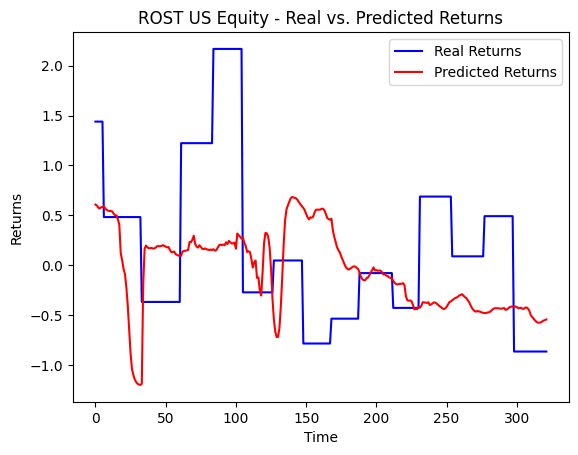

y vs y_pred: (348,) vs (348, 1)


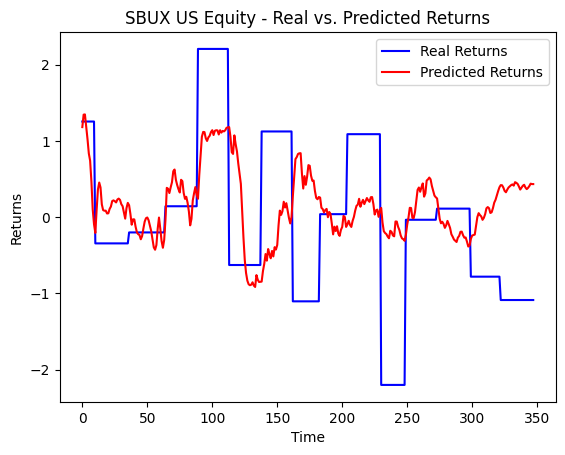

y vs y_pred: (321,) vs (321, 1)


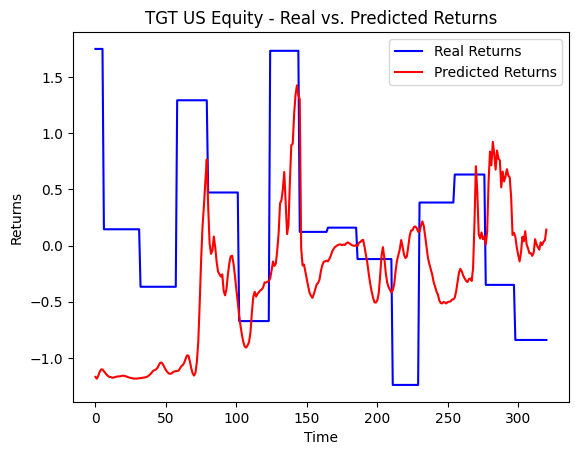

y vs y_pred: (318,) vs (318, 1)


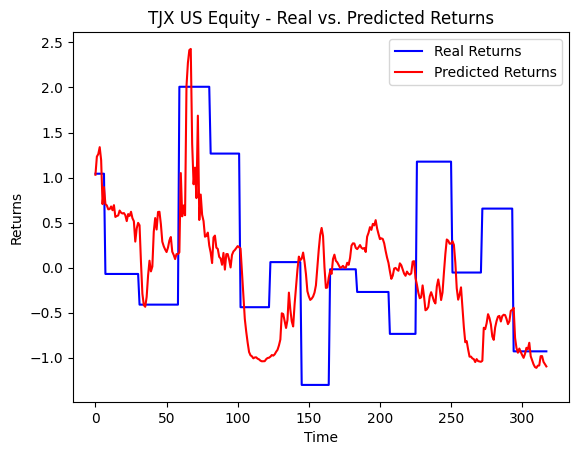

y vs y_pred: (321,) vs (321, 1)


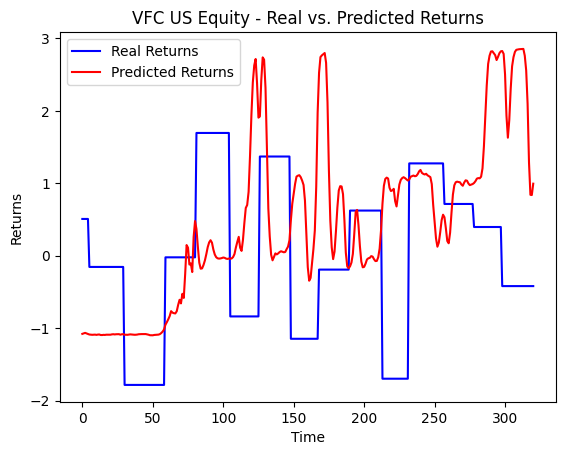

y vs y_pred: (347,) vs (347, 1)


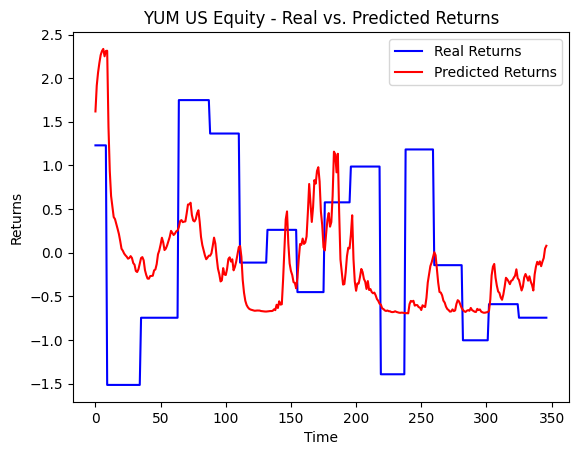

In [ ]:
pred25_next  = analyze(pred25_next, TASK, mode)


In [ ]:
pred25_next

AMZN US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                           -3.34477   
rmse                                                         0.986462   
mse                                                          0.973108   
y_preds             [[-0.40807194], [-0.34476805], [-0.13894251], ...   
y                   [1.2769308053014492, 1.2769308053014492, 1.276...   

                                                       APTV US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.126233   
rmse                                                         1.049114   
mse                                                           1.10064   
y_preds             [[0.719296], [0.65734607], [0.6123137], [0.629...   
y                   [1.3736792105671496, 1.3736792105671496, 1.373...   

                                                        AZO US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                           0.433224   
rmse                                                         0.804185   
mse                                                          0.646713   
y_preds             [[-0.06810599], [0.6196454], [0.5519039], [0.3...   
y                   [-0.4251703907794252, -0.4251703907794252, -0....   

                                                       BKNG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -1.075469   
rmse                                                         1.217578   
mse                                                          1.482496   
y_preds             [[0.79968], [0.75922716], [0.7391227], [0.7854...   
y                   [0.8422862872939317, 0.8422862872939317, 0.842...   

                                                        CCL US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.419739   
rmse                                                         1.169411   
mse                                                          1.367522   
y_preds             [[0.506468], [0.41526133], [0.33635372], [0.28...   
y                   [0.12703886919563015, 0.12703886919563015, 0.1...   

                                                        CMG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.293668   
rmse                                                         1.133435   
mse                                                          1.284675   
y_preds             [[0.041716494], [-0.09602702], [-0.16180298], ...   
y                   [1.7053823600424645, 1.7053823600424645, 1.705...   

                                                         DG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -1.870993   
rmse                                                         1.613632   
mse                                                          2.603807   
y_preds             [[0.4449288], [0.38959718], [0.3009952], [0.13...   
y                   [-0.059942791311259284, -0.059942791311259284,...   

                                                       EBAY US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.507101   
rmse                                                         1.161013   
mse                                                          1.347952   
y_preds             [[1.0346477], [0.925952], [0.9158921], [0.8943...   
y                   [1.6757256735

### One model all stock

In [ ]:
# Initializing the Neural Network based on LSTM
# implemented in this paper: https://www.sciencedirect.com/science/article/pii/S1877050920304865?via%3Dihub
def create_model(inputcol, lr, inputrow = LOOKBACK):
    model = Sequential([
        LSTM(96, return_sequences=True, input_shape=(inputrow, inputcol)),  # input_shape matches the features of X_train
        Dropout(0.2),
        LSTM(32),  # Last LSTM layer should not return sequences
        Dropout(0.2),
        Dense(1, activation='linear')  # Single unit for regression output
    ])
    # Compiling the Neural Network
    model.compile(optimizer = Adam(learning_rate=lr, clipvalue=0.5), loss='mean_squared_error')
    return model

def train_aggregate_model_tune(train_df = None, val_df = None, task = None, lr = None,  N_epoch = 70, batchsize = 64):
  """
  train on all stock data, but used to predict individual stocks.
  data: in stocks25 format
  return: dict pred25 that contains evaluation stats and y_pred vs y for each stock.
          {'stockname':{'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}...}
  """
  X_train = train_df['X_train']
  y_train = train_df['y_train']
  y_train = y_train*100
  for k,v in train_df.items(): # k is the dataset name: X_train, y_val .etc
    if k == 'X_train':
      single_day_feature_dim = v.shape[2]
      break
  assert single_day_feature_dim == 90

  stock_model = create_model(single_day_feature_dim, lr)
  es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
  rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
  mcp = ModelCheckpoint(filepath=f'weights_task_{task}_aggregate_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
  tb = TensorBoard('logs')
  def lr_scheduler(epoch, lr):
    if epoch < 45:
      return lr
    else:
      return lr * tf.math.exp(-0.1)
  lr_scheduler = LearningRateScheduler(lr_scheduler, verbose=1)
  stock_history = stock_model.fit(X_train, y_train, shuffle=True, epochs=N_epoch, callbacks=[es, rlr, mcp, tb, lr_scheduler], validation_split=0.2, verbose=1, batch_size=batchsize)
  SAVE_PATH = f'/content/gdrive/MyDrive/lazard/models/task_{task}/task_{task}_aggregate_model.h5'
  stock_model.save(SAVE_PATH)

  pred25 = {}
  for key,val in val_df.items():
    print(f'\n\n-------------------{key}--------------------')
    stock_X_val = val["X_val"]
    stock_y_val = val['y_val']
    stock_y_val = stock_y_val*100

    # predict
    y_preds = stock_model.predict(stock_X_val)
    r_squared_adjusted = r2_score(stock_y_val, y_preds)
    mse = mean_squared_error(stock_y_val, y_preds)
    rmse = np.sqrt(mse)
    pred_org = {'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}
    pred25[key]=pred_org

  return pred25

In [ ]:
TASK = 'next'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1
mode = 'agg'

dfall['X_train'][0].shape

(60, 90)

In [ ]:
TASK = 'next'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1
mode = 'agg'

pred25_aggregate_next = train_aggregate_model_tune(train_df = dfall, val_df = df25, lr = 0.005, task = TASK, N_epoch = 50, batchsize = 32)


Epoch 1: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 1/50
339/339 [==============================] - ETA: 0s - loss: 5742.3823
Epoch 1: val_loss improved from inf to 8124.61035, saving model to weights_task_next_aggregate_model.h5
339/339 [==============================] - 11s 16ms/step - loss: 5742.3823 - val_loss: 8124.6104 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 2/50
338/339 [============================>.] - ETA: 0s - loss: 3459.0854
Epoch 2: val_loss improved from 8124.61035 to 7712.18604, saving model to weights_task_next_aggregate_model.h5
339/339 [==============================] - 4s 10ms/step - loss: 3458.2488 - val_loss: 7712.1860 - lr: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 3/50
337/339 [============================>.] - ETA: 0s - loss: 2325.3818
Epoch 3: val_loss did not improve from 7712.18604
339/339 [==============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




-------------------AMZN US Equity--------------------
13/13 [==============================] - 1s 4ms/step


-------------------APTV US Equity--------------------
10/10 [==============================] - 0s 4ms/step


-------------------AZO US Equity--------------------
10/10 [==============================] - 0s 4ms/step


-------------------BKNG US Equity--------------------
11/11 [==============================] - 0s 4ms/step


-------------------CCL US Equity--------------------
10/10 [==============================] - 0s 4ms/step


-------------------CMG US Equity--------------------
11/11 [==============================] - 0s 5ms/step


-------------------DG US Equity--------------------
10/10 [==============================] - 0s 4ms/step


-------------------EBAY US Equity--------------------
11/11 [==============================] - 0s 4ms/step


-------------------F US Equity--------------------
13/13 [==============================] - 0s 5ms/step


-------------------GM US 

y vs y_pred: (410,) vs (410, 1)


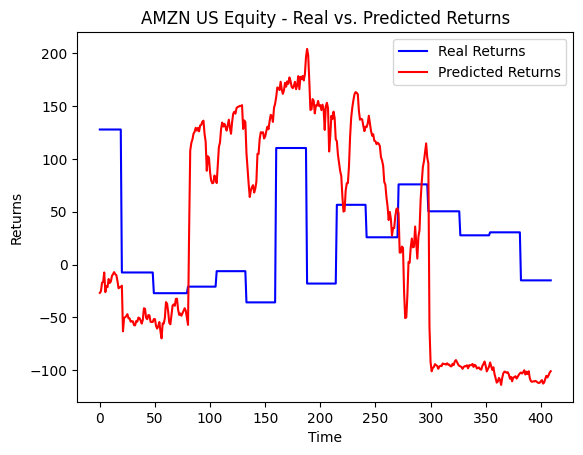

y vs y_pred: (316,) vs (316, 1)


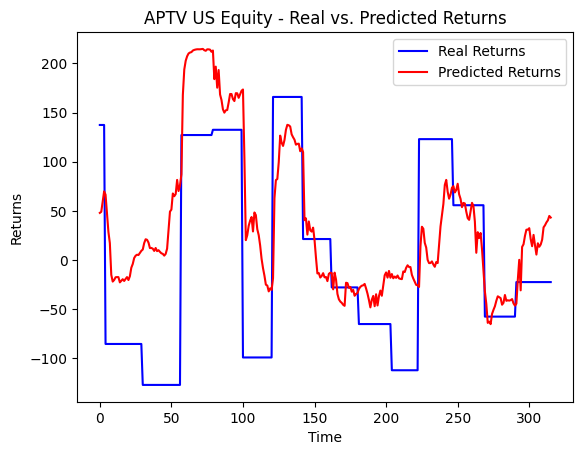

y vs y_pred: (314,) vs (314, 1)


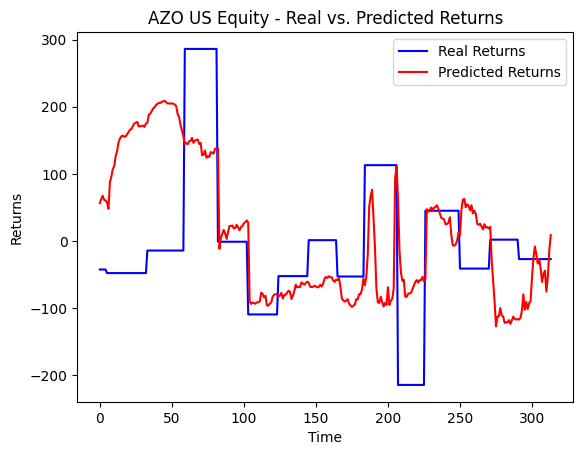

y vs y_pred: (324,) vs (324, 1)


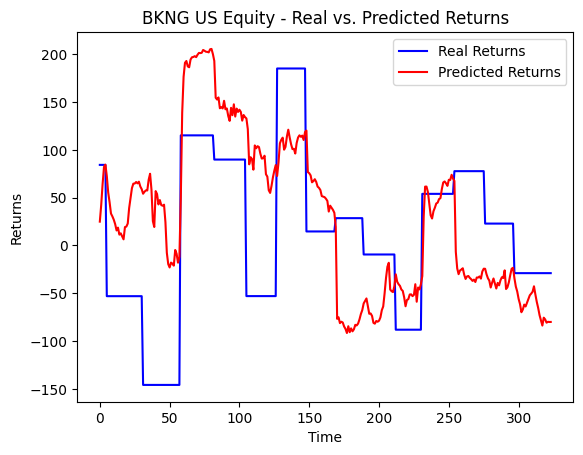

y vs y_pred: (314,) vs (314, 1)


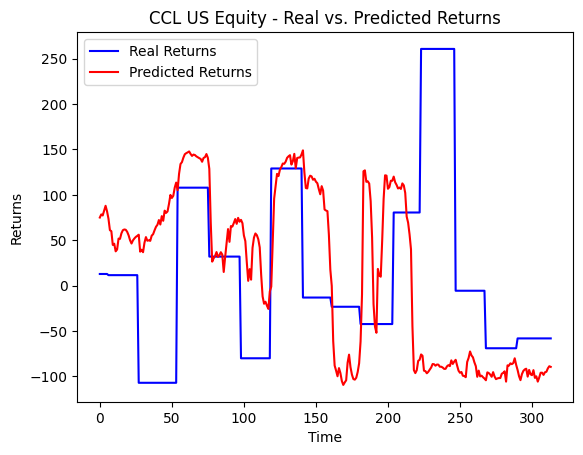

y vs y_pred: (325,) vs (325, 1)


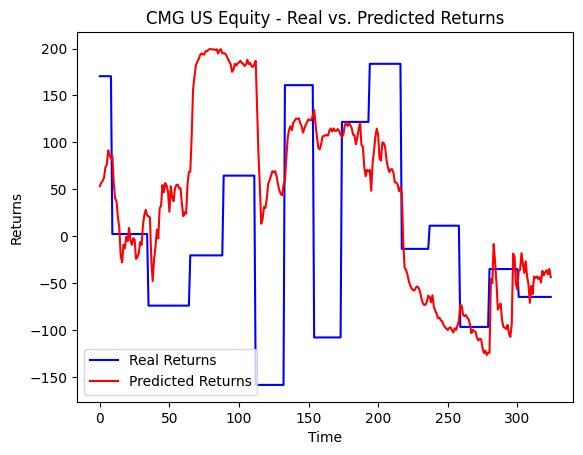

y vs y_pred: (306,) vs (306, 1)


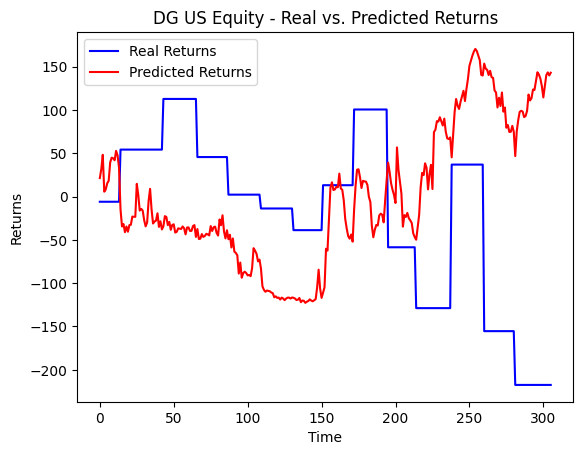

y vs y_pred: (325,) vs (325, 1)


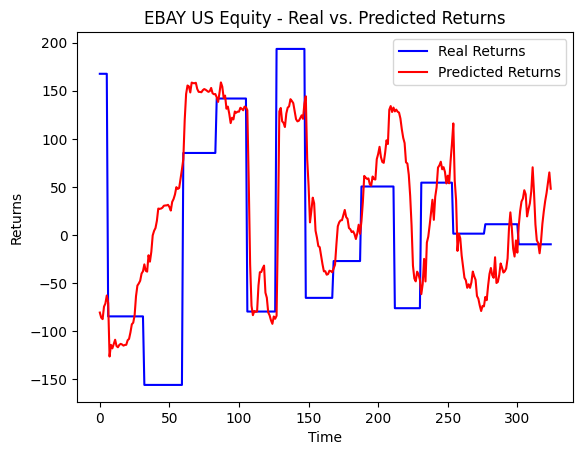

y vs y_pred: (394,) vs (394, 1)


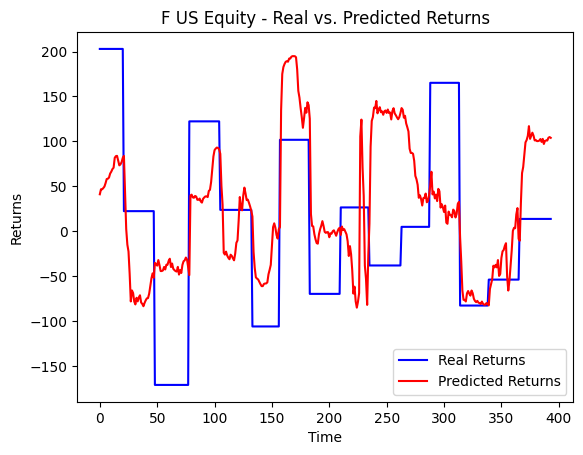

y vs y_pred: (418,) vs (418, 1)


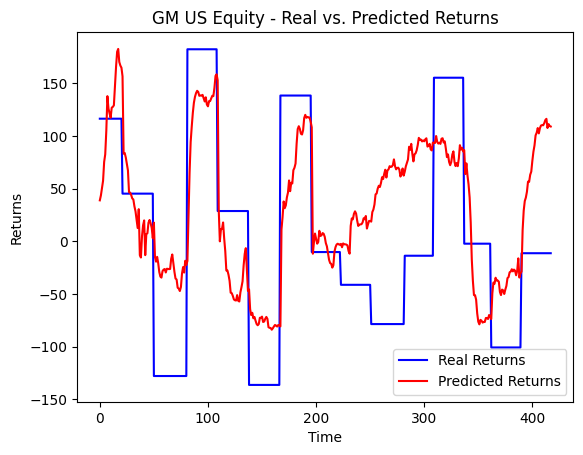

y vs y_pred: (330,) vs (330, 1)


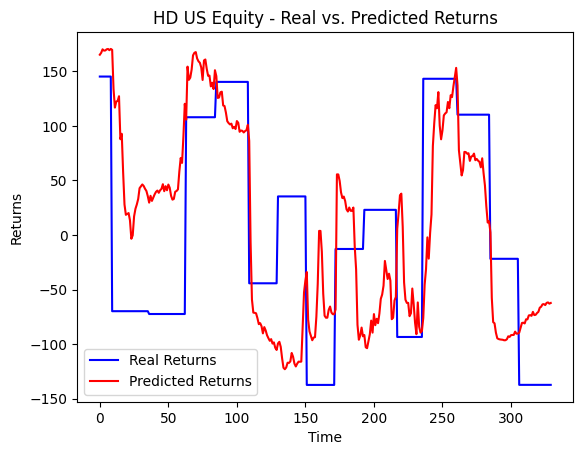

y vs y_pred: (317,) vs (317, 1)


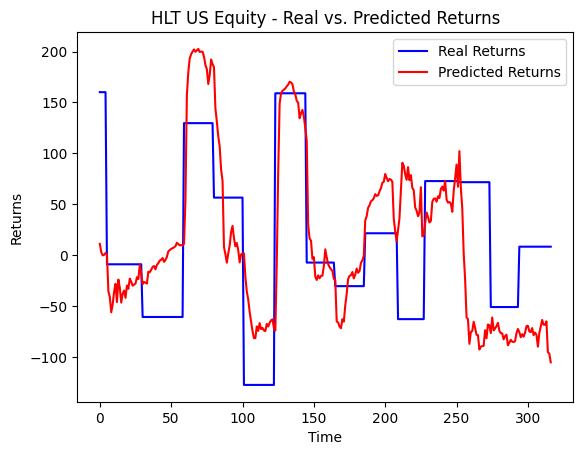

y vs y_pred: (325,) vs (325, 1)


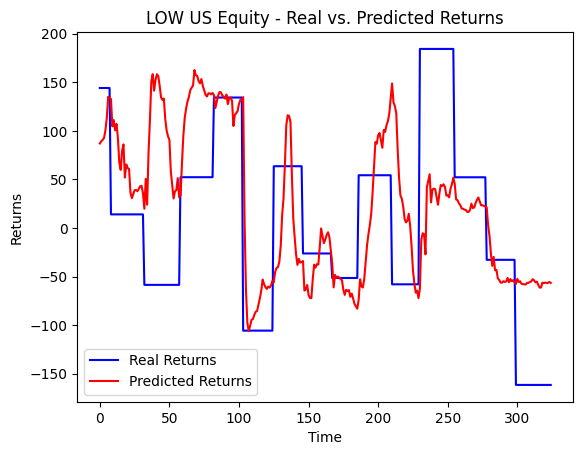

y vs y_pred: (324,) vs (324, 1)


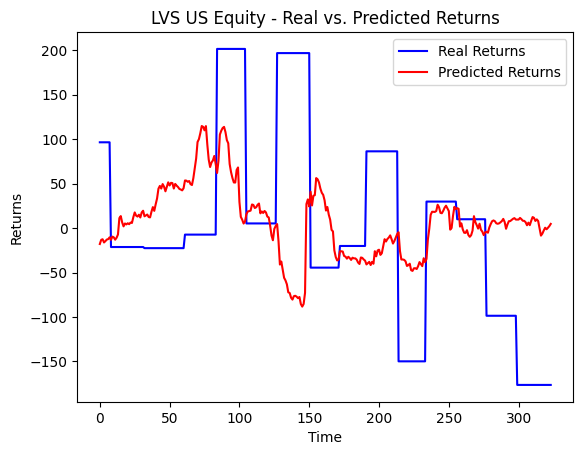

y vs y_pred: (341,) vs (341, 1)


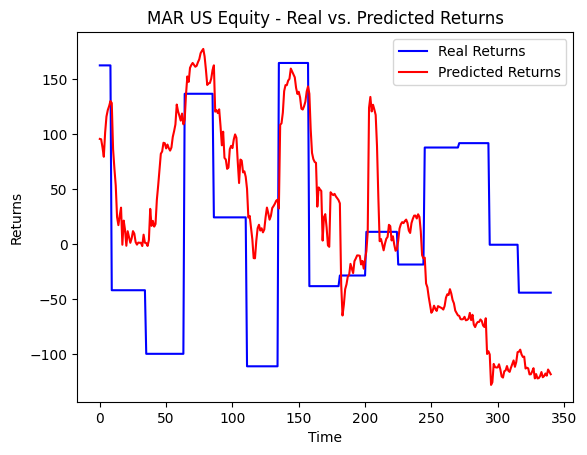

y vs y_pred: (336,) vs (336, 1)


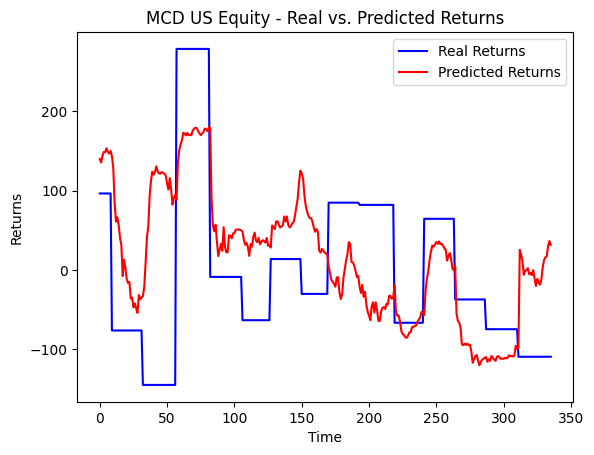

y vs y_pred: (346,) vs (346, 1)


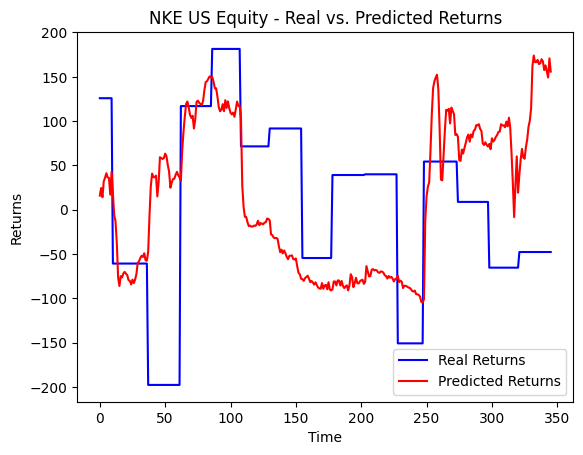

y vs y_pred: (316,) vs (316, 1)


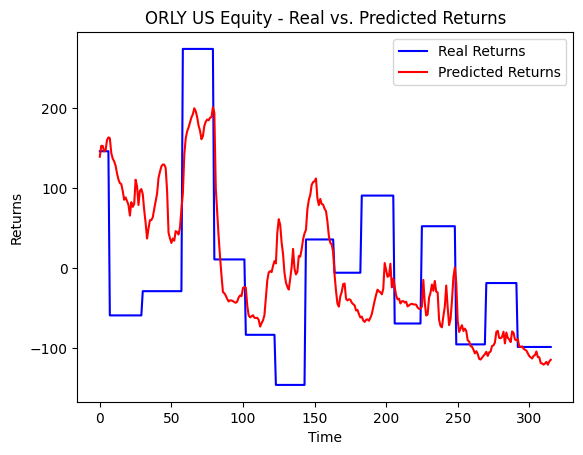

y vs y_pred: (319,) vs (319, 1)


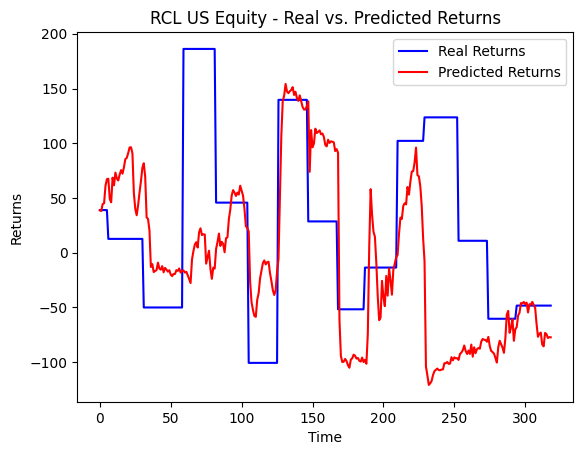

y vs y_pred: (322,) vs (322, 1)


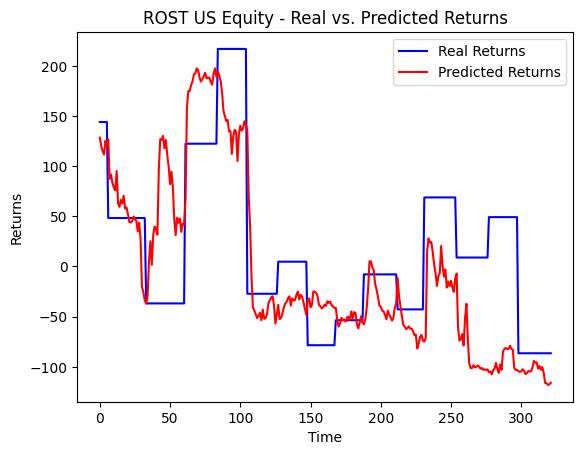

y vs y_pred: (348,) vs (348, 1)


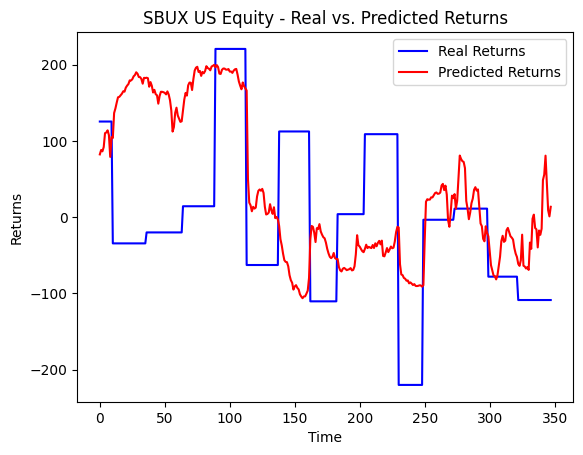

y vs y_pred: (321,) vs (321, 1)


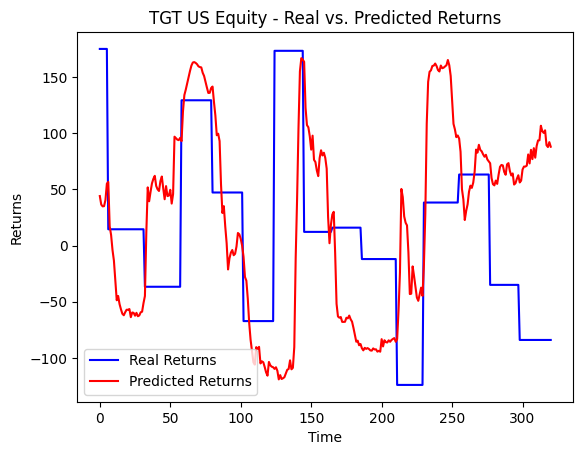

y vs y_pred: (318,) vs (318, 1)


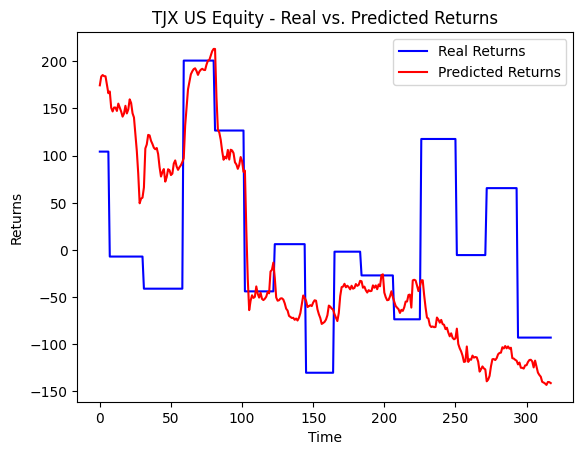

y vs y_pred: (321,) vs (321, 1)


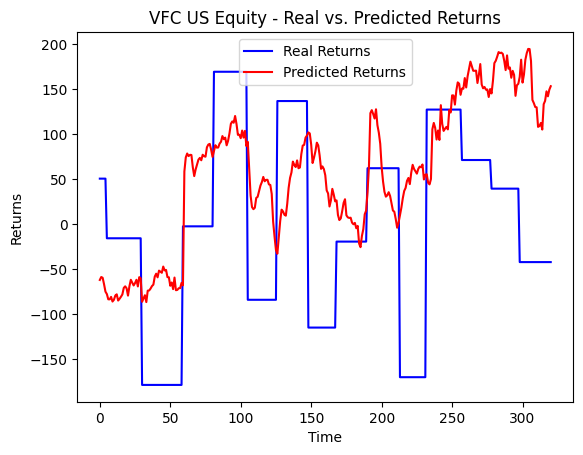

y vs y_pred: (347,) vs (347, 1)


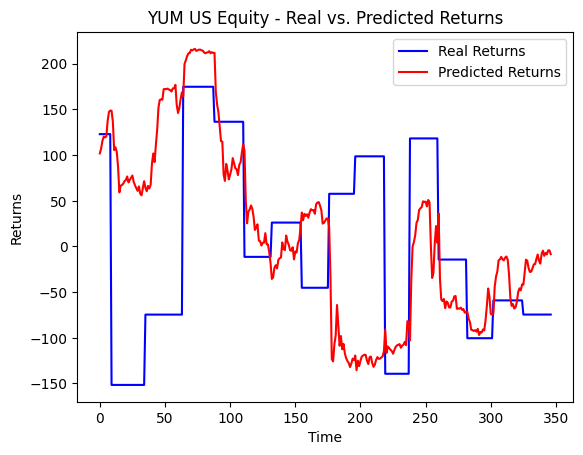

In [ ]:
pred25_aggregate_next  = analyze(pred25_aggregate_next, TASK, mode)


In [ ]:
pred25_aggregate_next

AMZN US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -4.482296   
rmse                                                       110.809863   
mse                                                      12278.825785   
y_preds             [[-26.783958], [-25.189724], [-17.31532], [-16...   
y                   [127.69308053014493, 127.69308053014493, 127.6...   

                                                       APTV US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                           0.330497   
rmse                                                        80.888154   
mse                                                       6542.893466   
y_preds             [[47.89802], [48.984745], [59.548176], [69.738...   
y                   [137.36792105671495, 137.36792105671495, 137.3...   

                                                        AZO US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.261733   
rmse                                                       119.986863   
mse                                                      14396.847259   
y_preds             [[56.408123], [62.675213], [67.36831], [61.055...   
y                   [-42.51703907794252, -42.51703907794252, -42.5...   

                                                       BKNG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.125763   
rmse                                                        89.673068   
mse                                                       8041.259174   
y_preds             [[24.868267], [42.4478], [64.38547], [82.14394...   
y                   [84.22862872939318, 84.22862872939318, 84.2286...   

                                                        CCL US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                           -0.74545   
rmse                                                       129.663157   
mse                                                      16812.534183   
y_preds             [[74.93966], [78.41281], [77.24511], [82.51411...   
y                   [12.703886919563015, 12.703886919563015, 12.70...   

                                                        CMG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                           -0.38188   
rmse                                                       117.144089   
mse                                                      13722.737686   
y_preds             [[53.574238], [57.01595], [59.08503], [62.3061...   
y                   [170.53823600424644, 170.53823600424644, 170.5...   

                                                         DG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -1.520023   
rmse                                                       151.178671   
mse                                                      22854.990681   
y_preds             [[21.329903], [31.654922], [48.187042], [5.631...   
y                   [-5.9942791311259285, -5.9942791311259285, -5....   

                                                       EBAY US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                           0.154959   
rmse                                                        86.937063   
mse                                                       7558.052965   
y_preds             [[-80.47323], [-85.74284], [-87.30773], [-74.3...   
y                   [167.57256735